In [2]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import complex_ode
from scipy.integrate import ode
from scipy.integrate import odeint
from scipy.linalg import circulant
from random import random
from scipy.io.wavfile import read
from numpy import asarray
from numpy import savetxt


mode_index = np.arange(-40,41,1,int)
simulation_time = np.arange(0,16,1,int)

# 1. one resonator unit

From the paper, we know that the dynamic equation a resonator can be described by 
\begin{equation}
\frac{da}{dt}= (i\omega _0 - \frac{1}{\tau})a+k \cdot S^{in}
\end{equation}
, where $a$ and $|a|^2$ are resonance field and energe. $\omega_0$ is resonance frequency. $\frac{1}{\tau}$ is total decay rate. k is coupling coefficient. For a continuous-time dynamic system, the impulse is modeled as the Dirac delta function $S^{in}(t) = \delta (t-t_0)$.


Now, we know the impulse response (resonance amplitude $|a|$) of a resonator is: 
\begin{equation}
R(t) = |a| =k \cdot e^{-\frac{1}{\tau}(t-t_0 )}
\end{equation}

Thoughs: for $S^{in}$, both Sin function and Gasussian function will be implemented. Both methods are shown below:

In [3]:
def one_res_sin(w, tau, k): 
    def one_res (t,a):
        da = (1j * w - 1/tau) * a + k * 0.1*np.sin(t)
        return da
    
    a_initial = 0

    r = complex_ode(one_res)
    r.set_initial_value(a_initial, 0)

    max_time = 30
    depth = 0.001

    time_interval = []
    amplitude_a = []
    real_a = []
    while r.successful() and r.t < max_time:
        x = r.t+ depth
        y = r.integrate(x)
        amplitude_a.append (abs(y))
        real_a.append(y.real)
        time_interval.append (x)

    #plt.plot (time_interval, amplitude_a, label='$\omega = %.0f$, tau = %.1f, $k=%.0f$' %(w,tau,k))
    #plt.title('1 Resonator with Sin Function')
    #plt.xlabel('Simulation Time (s)')
    #plt.ylabel('Impluse response (resonance amplitude)')
    #plt.legend()
    #plt.show()

    plt.plot (time_interval, real_a, label='$\omega = %.0f$, tau = %.1f, $k=%.0f$' %(w,tau,k))
    plt.title('Real part of 1 Resonator with Sin Function')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Impluse response (resonance amplitude)')
    plt.legend()
    plt.show()

In [4]:
def one_res_gau(w, tau, k): 
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    def one_res (t,a):
        da = (1j * w - 1/tau) * a + k * gaussian(t, 2, 0.3)
        return da

    a_initial = 0

    r = complex_ode(one_res)
    r.set_initial_value(a_initial, 0)

    max_time = 30
    depth = 0.001

    time_interval = []
    amplitude_a = []
    real_a = []
    
    while r.successful() and r.t < max_time:
        x = r.t+ depth
        y = r.integrate(x)
        amplitude_a.append (abs(y))
        real_a.append(y.real)
        time_interval.append (x)

    plt.plot (time_interval, amplitude_a, label='$\omega = %d$, tau = %d, $k=%d$' %(w,tau,k))
    plt.title('1 Resonator with Gaussian Function')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Impluse response (resonance amplitude)')
    plt.legend()
    plt.show()

    plt.plot (time_interval, real_a, label='$\omega = %.0f$, tau = %.1f, $k=%.0f$' %(w,tau,k))
    plt.title('Real part of 1 Resonator with Gaussian Function')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Impluse response (resonance amplitude)')
    plt.legend()
    plt.show()

Now, for both Sin and Gasussian input, we start to compare the effect of different parameters: the resonance frequency $\omega$, the total decay rate $1/ \tau$, and the coupling coefficient $k$

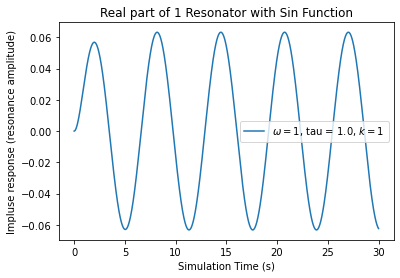

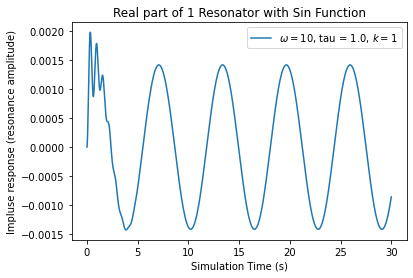

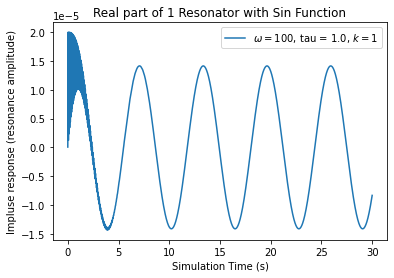

In [5]:
one_res_sin(1,1,1)
one_res_sin(10,1,1)
one_res_sin(100,1,1)

From the plots, we notice that when the value of $\omega$ increases, the effect of original input $S^{in}$ decreases. It makes sense because when $\omega$ increases, it dominates the ODE system.

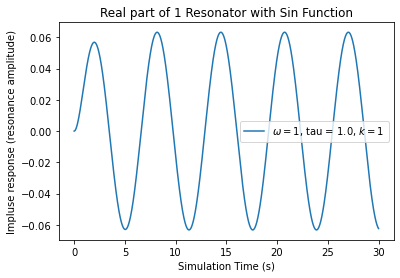

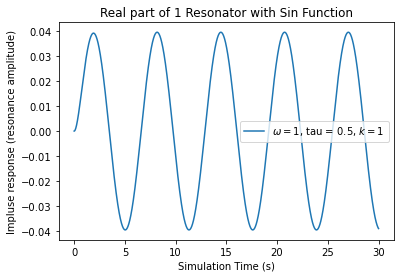

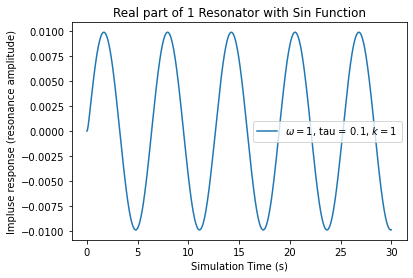

In [6]:
one_res_sin(1,1,1)
one_res_sin(1,0.5,1)
one_res_sin(1,0.1,1)

When $\frac{1}{\tau}$ is big, the rate of decrease of impulse response is large.

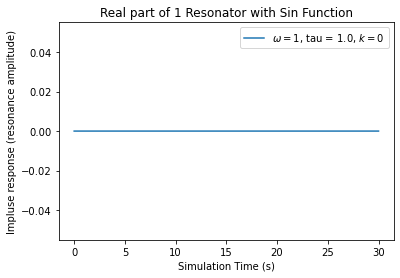

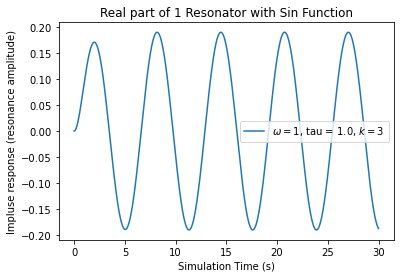

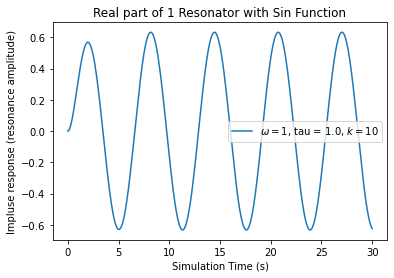

In [7]:
one_res_sin(1,1,0)
one_res_sin(1,1,3)
one_res_sin(1,1,10)

When k is big, the effect of original input $S^{in}$ on the system is big. 

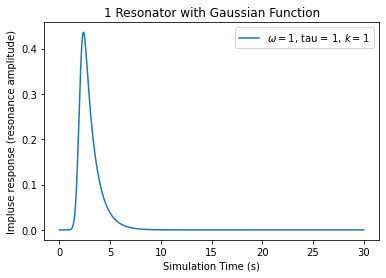

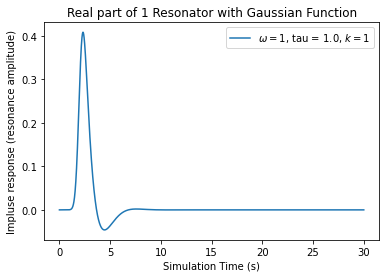

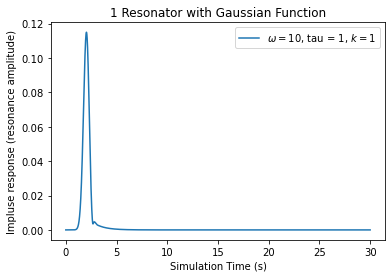

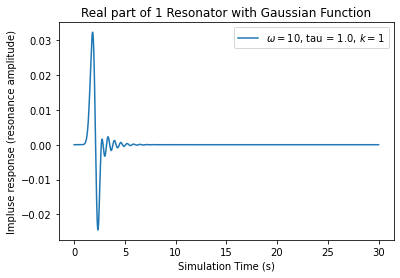

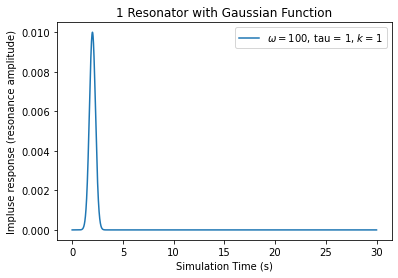

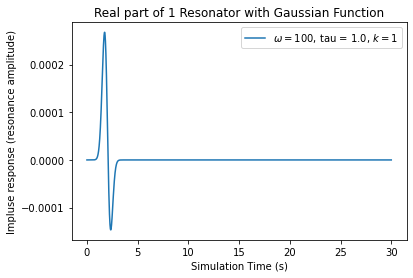

In [8]:
one_res_gau(1,1,1)
one_res_gau(10,1,1)
one_res_gau(100,1,1)

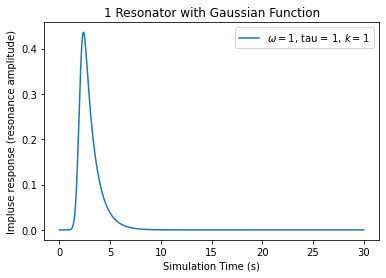

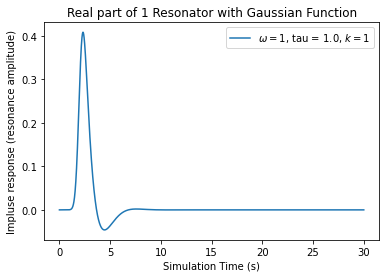

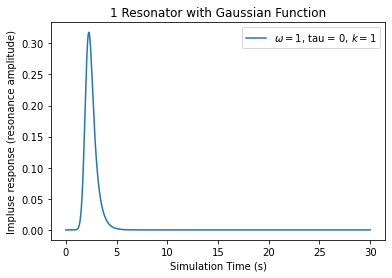

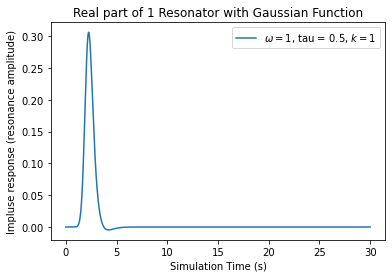

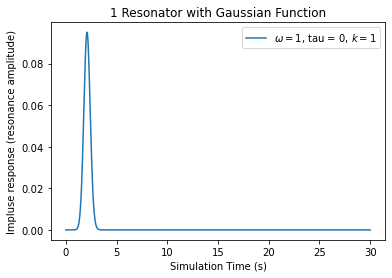

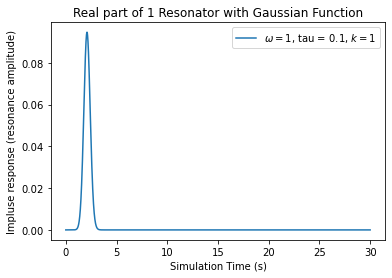

In [9]:
one_res_gau(1,1,1)
one_res_gau(1,0.5,1)
one_res_gau(1,0.1,1)

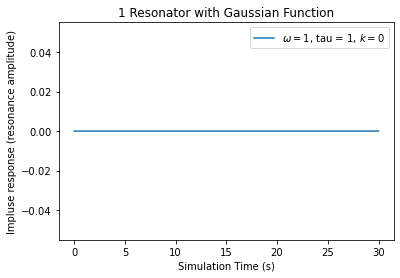

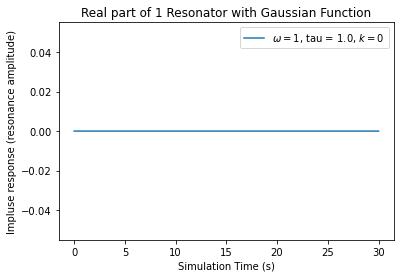

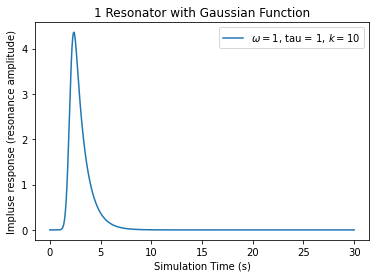

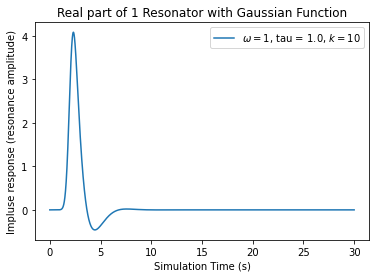

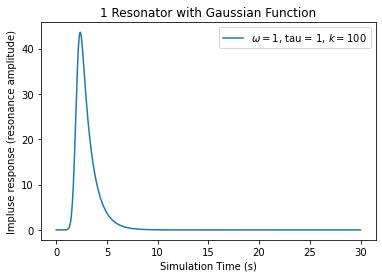

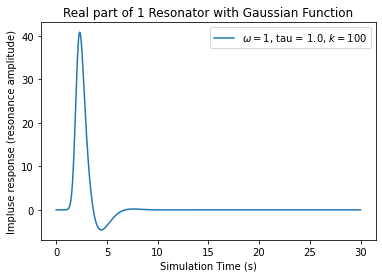

In [10]:
one_res_gau(1,1,0)
one_res_gau(1,1,10)
one_res_gau(1,1,100)

To sum up, we can tell that the simulation of the dynamic equation is compatible with the impulse response equation proposed in the paper. It obeys exponential decay for both linear and non-linear resonance system.

# 2. Coupled resonators system

Now, for many resonators coupled together, we can define it as a scalable RNN system by the following equations
\begin{equation}
\frac{da}{dt}= (i\Omega - \Gamma_e - H_{int})a+K^T \cdot S_t
\end{equation}
, where the diagonal matrices $\Omega$ is resonance frequency, diagonal matrice $\Gamma_e$ is the decay rate into channels, and $H_{int}$ is the coupling bewteen resonators. Moreover, $K$ represents the coupling between resonators and waveguides. $S_t$ is a continuous input sequence. 

From the paper, we know that there are three waveguides for signal input. Thus, S_t can be considered as a 3X1 matrix, where each column represents the signal input of one waveguide.

Importantly, we know that $H_{int} = \frac{K^{+} K}{2} - \Gamma_e$, and $K$ is defined by:
\begin{pmatrix}
k_1 exp(+i\beta_1 l_1) & ... & k_n exp(+i\beta_n l_n) &0 & ... &0 \\
k_1 exp(+i\beta_1 l_1) & ... & k_n exp(+i\beta_n l_n) &k_{n+1} exp(-i\beta_{n+1} l_{n+1}) & ... &k_{2n} exp(-i\beta_{2n} l_{2n}) \\
0 & ... & 0 &k_{n+1} exp(+i\beta_{n+1} l_{n+1}) & ... &k_{2n} exp(+i\beta_{2n} l_{2n})
\end{pmatrix}

Now, it comes to the significant part of this simulation: $k$ is the coupling coefficient of each resonator. $\beta$ is the wavevector of each resonator. $l$ represents the position of every resonator. 

Next step is the signal output $S_{out}$
\begin{equation}
S_t^{out} = e^{-j\beta L}(S_t^{in} - K^* \cdot a_t)
\end{equation}
, where $\beta$ and $L$ are wave vector and length of the waveguides

In [11]:
def signal_input_distribution (distribution):
    if distribution ==1:
        a = np.array([0, 0, 1])
    if distribution ==10:
        a = np.array([0, 1, 0])
    if distribution ==100:
        a = np.array([1, 0, 0])
    if distribution ==110:
        a = np.array([1, 1, 0])
    if distribution ==101:
        a = np.array([1, 0, 1])
    if distribution ==11:
        a = np.array([0, 1, 1])
    if distribution ==111:
        a = np.array([1, 1, 1])
    if distribution ==0:
        a = np.array([0, 0, 0])
    return(a)

In [12]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
mu = 3
sig = 0.3

In [13]:
# It is the general function that plot out the impluse response (amplitude of a) of each resonator,
#and the output power inside these three waveguides. 

# n is the number of resonators (= 2*n)
# Omega is the diagonal matrix of resonance frequency
# Gamma is the diagonal matrix of decay rate
# k is the diagonal matrix of coupling coefficient
# beta is the diagonal matrix of wavevector
# l is the diagonal matrix of resonator's position
# Importantly, input_type is the input distribution for three waveguides
def impulse_response (n, Omega, Gamma, k, beta, l, distribution):
    #Firstly, we need to find out the matrix for K (coupling coefficient).
    temp1 = np.array([complex(0, 0) for i in range(6*n)])
    for i in range(6*n):
        if (i< n):
            temp1[i] = k[i] * np.exp(complex(0, 1) *beta[i]*l[i])
        if (2*n<=i< 3*n):
            temp1[i] = k[i-2*n] * np.exp(complex(0, 1)*beta[i-2*n]*l[i-2*n])
        if (3*n<=i< 4*n):
            temp1[i] = k[i-2*n] * np.exp(-complex(0, 1)*beta[i-2*n]*l[i-2*n])
        if (5*n<=i <6*n):
            temp1[i] = k[i-4*n] * np.exp(complex(0, 1)*beta[i-4*n]*l[i-4*n])
    K = temp1.reshape(3,2*n)

    #From K, we can have the matrix H_int
    H_int = 0.5* K.conj().T @ K - Gamma

    #The seires of differential equations that indicates impluse response inside each resonator
    
    #Firstly, let's plug in the i. As is known, there are three waveguides with three 
    #seperate input signals.
    def coupled_res (t,a):
            S_in = gaussian(t, mu, sig) * signal_input_distribution(distribution)
            da = (1j * Omega - Gamma - H_int ) @ a + K.transpose() @ S_in
            return da

    
    #set initial inpulse response to be 0!!!! important.
    a_initial = np.array([complex(0, 0) for i in range(2*n)])
    a_initial[0] = 0

    r = complex_ode(coupled_res)
    r.set_initial_value(a_initial, 0)

    #Simulation time is 50s, which is enough for the simple simulation now. 
    max_time = 50
    depth = 0.001

    time_interval = []
    a_complex = []
    
    while r.successful() and r.t < max_time:
        x = r.t+ depth
        y = r.integrate(x)
        a_complex.append (y)
        time_interval.append (x)
        
    #saves the value of a and value of |a|. 
    a_complex = np.array (a_complex)
    a_amp = np.zeros((len(a_complex),len(a_complex[0])))
    a_real = np.zeros((len(a_complex),len(a_complex[0])))
    for i in range (len(a_complex)):
        for j in range (len(a_complex[0])):
            a_amp[i][j] = abs(a_complex[i][j])
            a_real[i][j] = a_complex[i][j].real

    
    #plots of each |a|
    #p1 = plt.pcolormesh(a_amp)
    #plt.colorbar(p1)
    #plt.title('System coupled by 2 X %.0f resonators' %(n))
    #plt.xlabel('mode index')
    #plt.ylabel('Amplitude (ms)')
    #plt.show()
    
    plt.plot (time_interval, a_amp[:,0], label = 'Resonators at row '+str(1), color ='tab:blue')
    plt.plot (time_interval, a_amp[:,n], label = 'Resonators at row '+str(2), color ='tab:orange')
    plt.title('2 X %.0f (Aplitude) resonators located in both rows (%.0f)' %(n, distribution))
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Impluse response (resonance amplitude)')
    plt.legend ()
    plt.show()
    
    plt.plot (time_interval, a_real[:,0], label = 'Resonators at row '+str(1), color ='tab:blue')
    plt.plot (time_interval, a_real[:,n], label = 'Resonators at row '+str(2), color ='tab:orange')
    plt.title('2 X %.0f (real part) resonators located in both rows (%.0f)' %(n, distribution))
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Impluse response (resonance amplitude)')
    plt.legend ()
    plt.show()
    
    for i in range (2*n):
        if (1+i//n == 1):
            name = 'tab:blue'
        if (1+i//n == 2):
            name ='tab:orange'
        plt.plot (time_interval, a_amp[:,i], label = 'Resonator at row '+str(1+i//n) +' position '+ str(1+i - n* (i//n)), color =name )
        plt.title('Dynamics of individual resonator')
        plt.xlabel('Simulation Time (s)')
        plt.ylabel('Impluse response (resonance amplitude)')
        plt.legend ()
        plt.show()
        
        plt.plot (time_interval, a_real[:,i], label = 'Resonator at row '+str(1+i//n) +' position '+ str(1+i - n* (i//n)), color =name )
        plt.title('(Real Part) Dynamics of individual resonator')
        plt.xlabel('Simulation Time (s)')
        plt.ylabel('Impluse response (resonance amplitude)')
        plt.legend ()
        plt.show()
    
    
    
    def S_in (t):
        y = gaussian(t, mu, sig) * signal_input_distribution(distribution)
        return y

    max_time = 12
    depth = 0.001
    
    time_interval = []
    
    i=0
    while i < max_time:
        i+=depth
        time_interval.append(i)
    
    S_out = []
    S_in_plot = []
    for i in range(len(time_interval)):
        aa = K.conj() @ a_complex[i]
        temp =  np.exp(-0.2*0.2*0.2)* (S_in(time_interval[i]) - aa)
        S_out.append(temp)
        S_in_plot.append(S_in(time_interval[i]))
    
    S1 =[]
    S2= []
    S3= []
    S_in_plot1 =[]
    S_in_plot2=[]
    
    S_in_plot3=[]
    for i in range (len(S_out)):
        S1.append(S_out[i][0])
        S2.append(S_out[i][1])
        S3.append(S_out[i][2])
        S_in_plot1.append(S_in_plot[i][0].real)
        S_in_plot2.append(S_in_plot[i][1].real)
        S_in_plot3.append(S_in_plot[i][2].real)
        
        
    
    plt.plot (time_interval, S1, label = 'Waveguide 1 output', color = 'tab:blue')
    plt.plot (time_interval, S2, label = 'Waveguide 2 output', color = 'tab:orange')
    plt.plot (time_interval, S3, label = 'Waveguide 3 output', color = 'tab:green')
    plt.plot (time_interval, S_in_plot1, label = 'Waveguide 1 signal input' , color = 'tab:red')
    plt.plot (time_interval, S_in_plot2, label = 'Waveguide 2 signal input', color = 'tab:purple')
    plt.plot (time_interval, S_in_plot3, label = 'Waveguide 3 signal input', color = 'tab:brown')
    plt.title('2 X %.0f Comparison between dynamics inside waveguides %.0f' %(n ,distribution))
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()  


        
        
        
    plt.plot (time_interval, S1, label = 'Waveguide 1 output', color = 'tab:blue')
    plt.plot (time_interval, S_in_plot1, label = 'Waveguide 1 signal input', color = 'tab:red')
    plt.title('Dynamics inside waveguide 1')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()
    

    plt.plot (time_interval, S2, label = 'Waveguide 2 output', color = 'tab:orange')
    plt.plot (time_interval, S_in_plot2, label = 'Waveguide 2 signal input', color = 'tab:purple')
    plt.title('Dynamics inside waveguide 2')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()
    
    plt.plot (time_interval, S3, label = 'Waveguide 3 output', color = 'tab:green')
    plt.plot (time_interval, S_in_plot3, label = 'Waveguide 3 signal input', color = 'tab:brown')
    plt.title('Dynamics inside waveguide 3')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()


    
    return ()

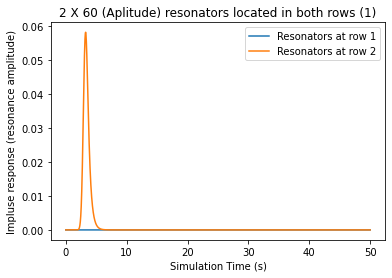

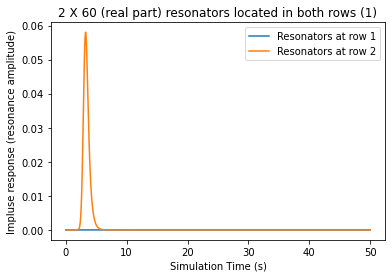

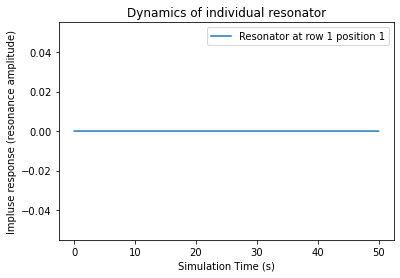

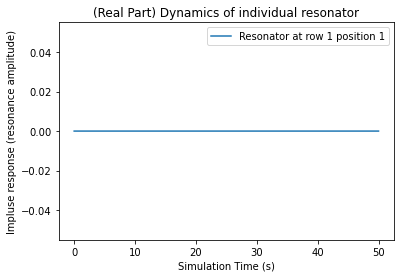

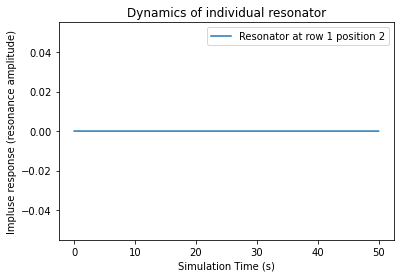

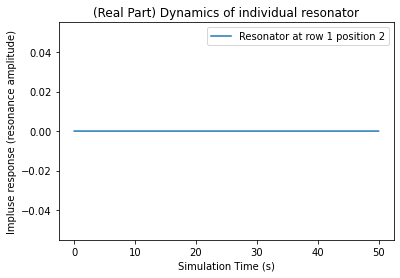

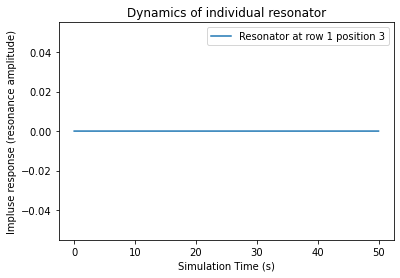

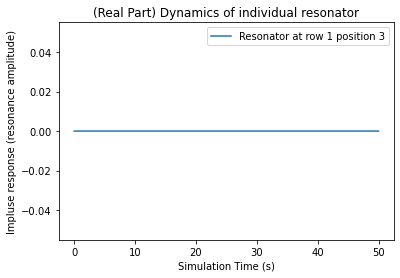

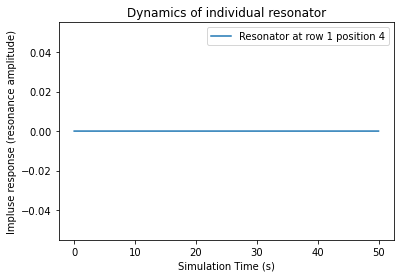

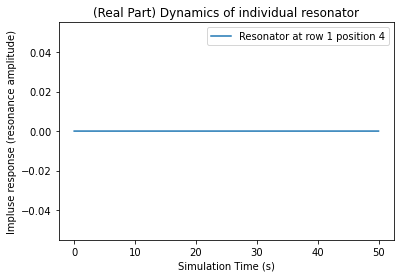

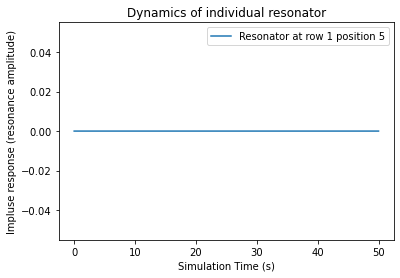

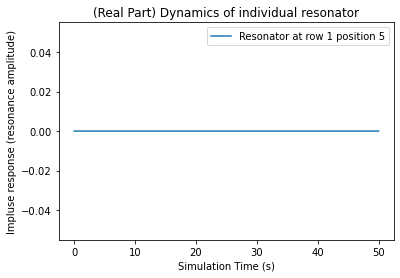

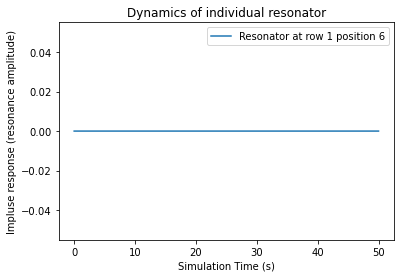

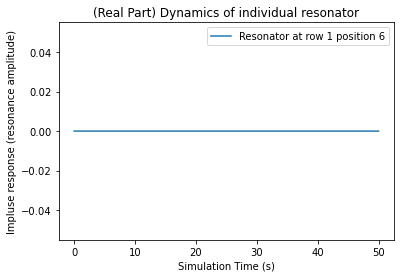

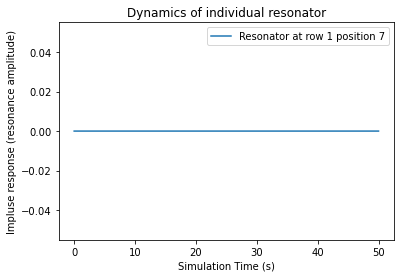

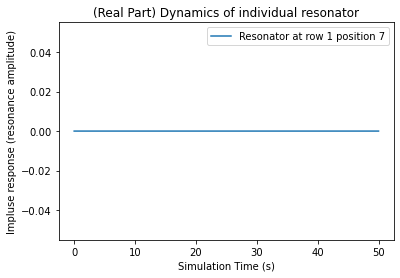

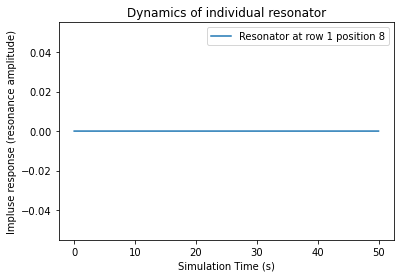

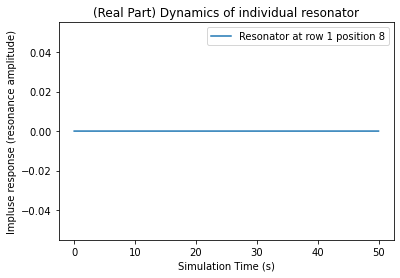

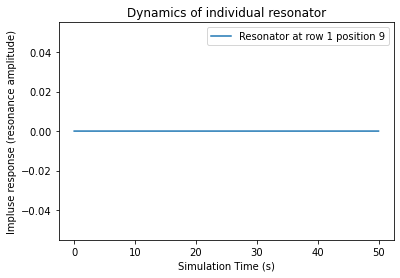

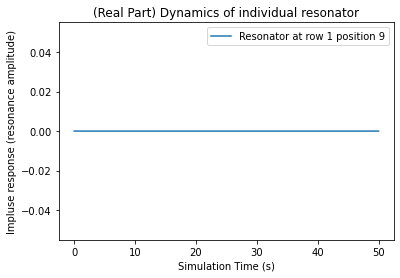

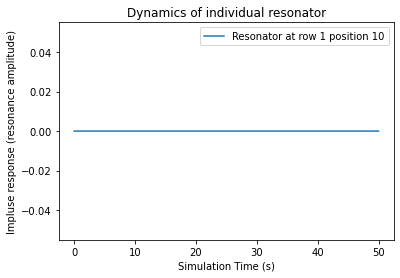

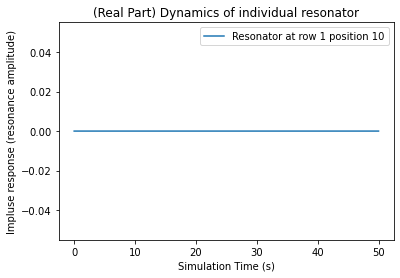

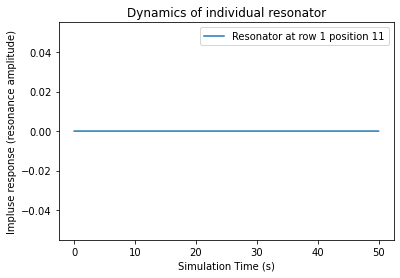

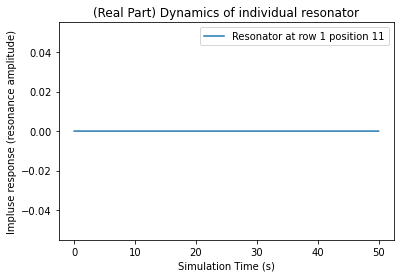

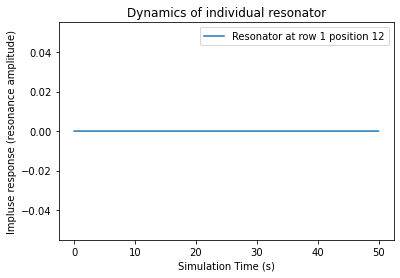

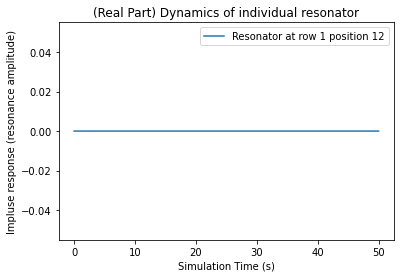

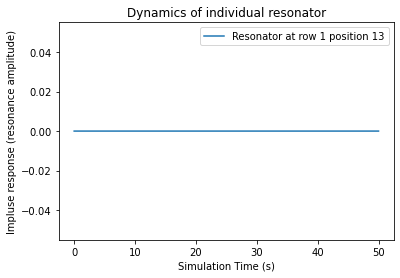

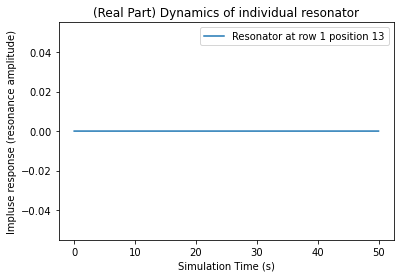

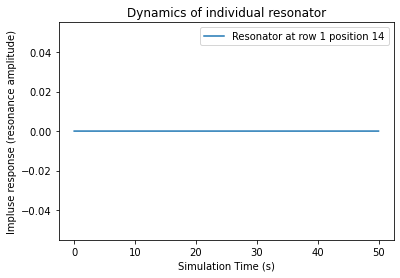

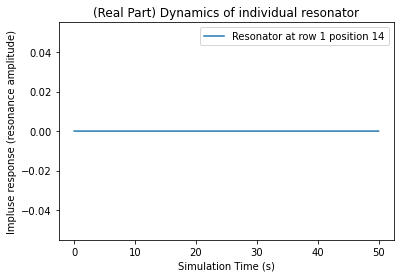

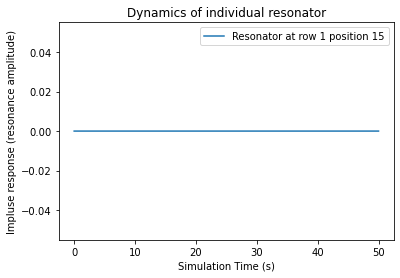

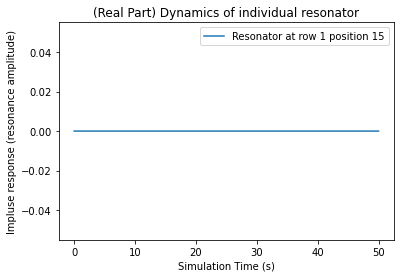

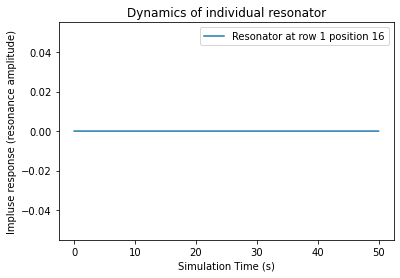

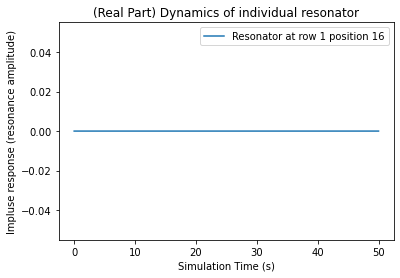

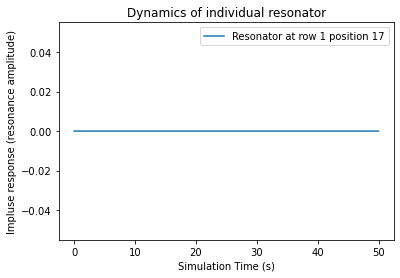

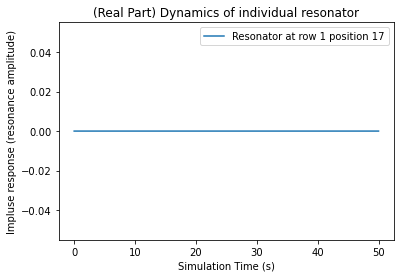

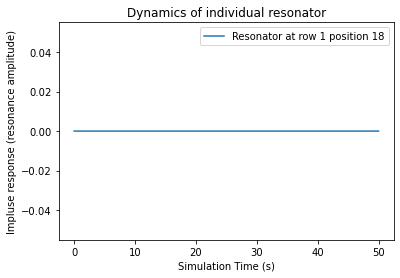

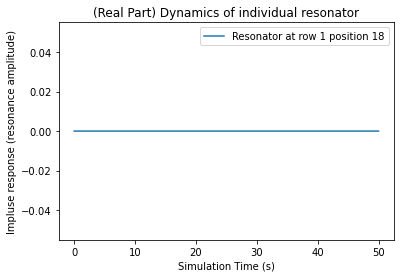

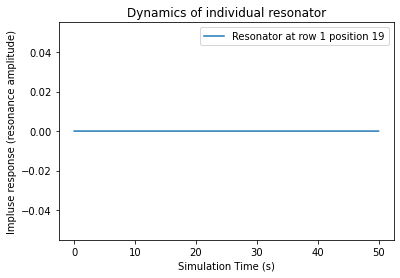

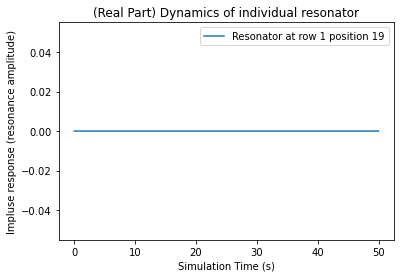

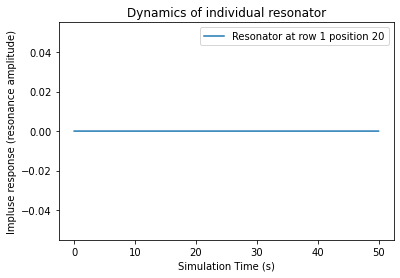

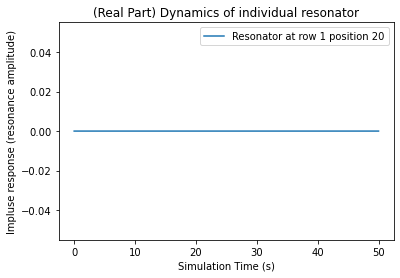

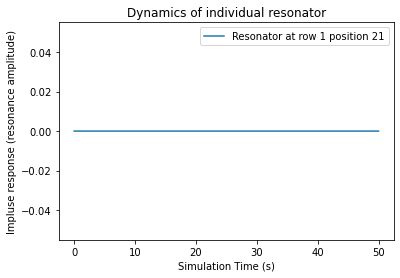

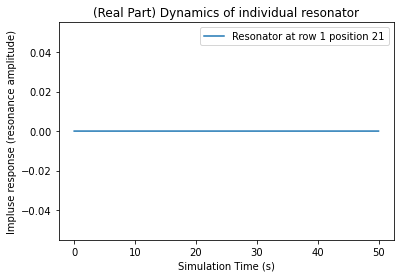

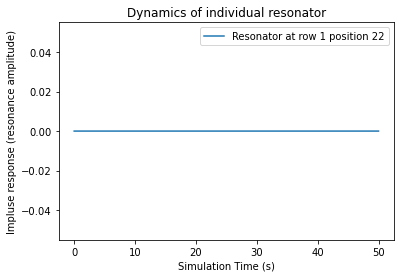

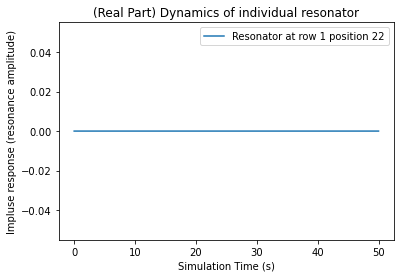

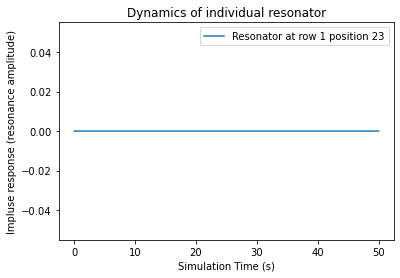

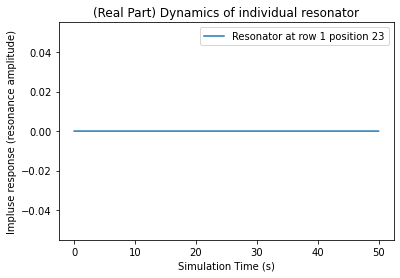

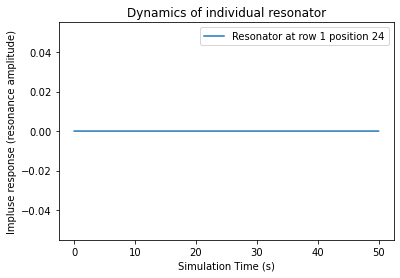

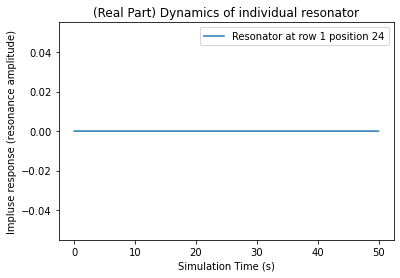

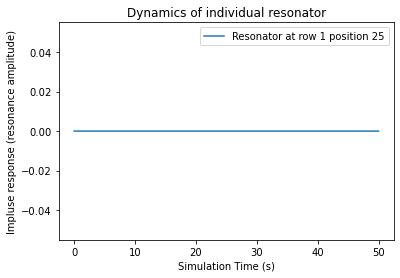

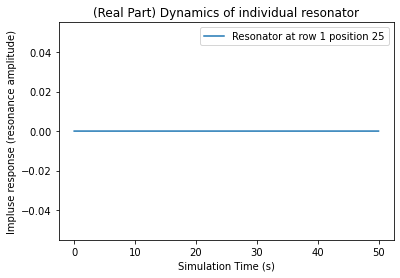

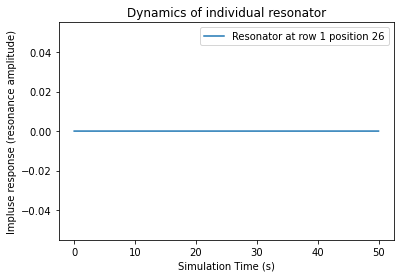

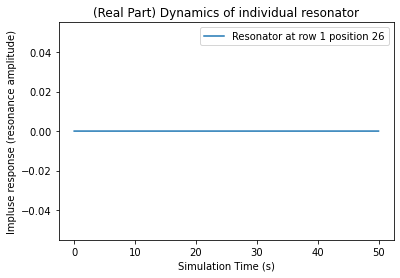

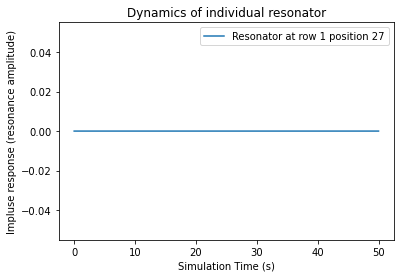

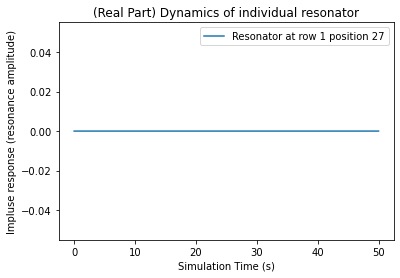

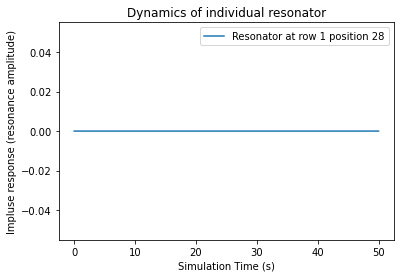

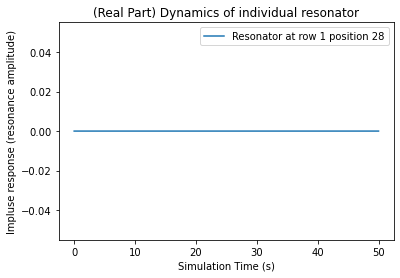

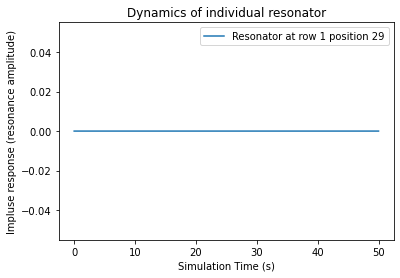

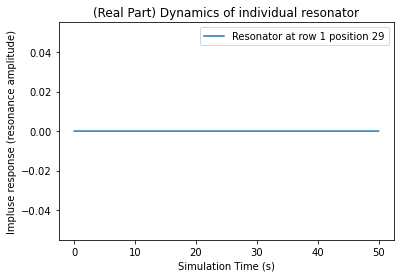

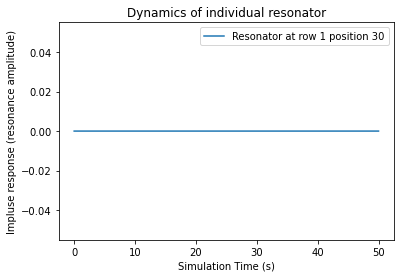

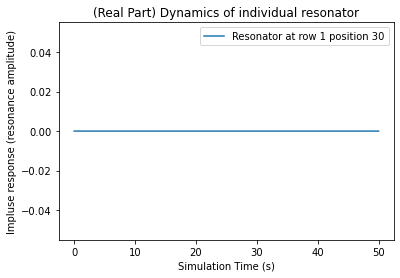

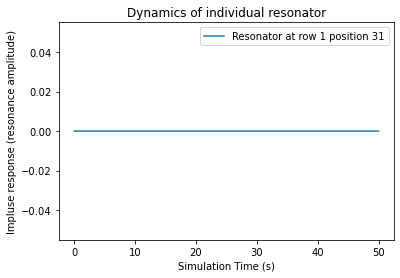

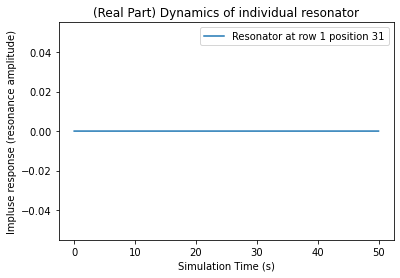

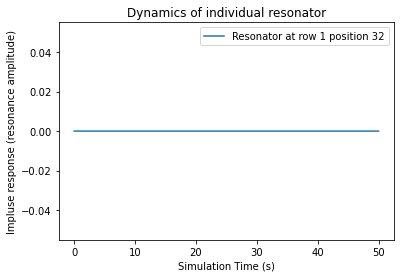

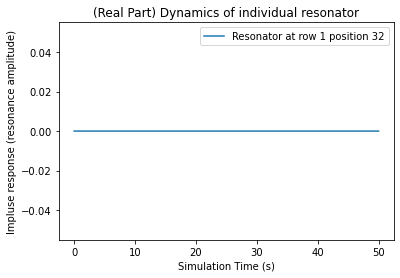

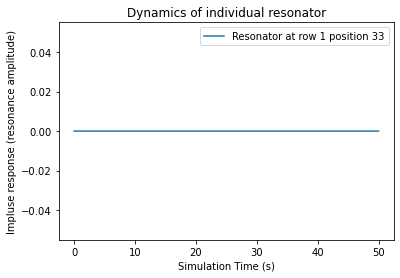

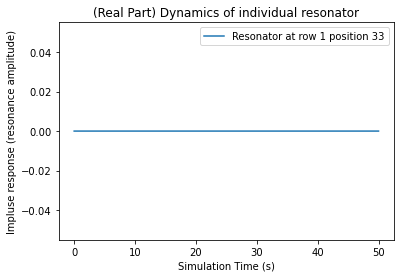

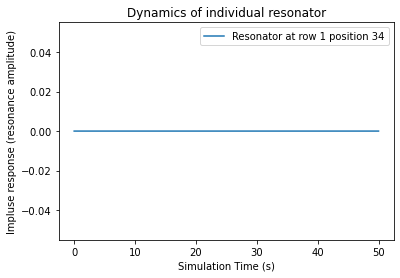

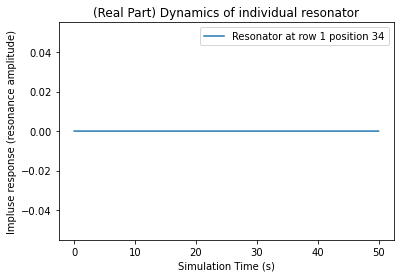

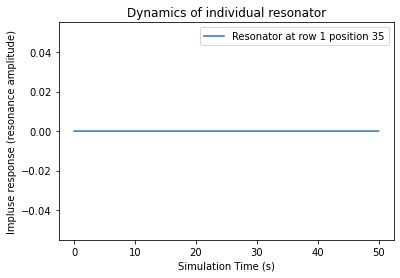

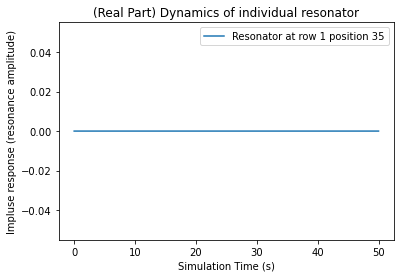

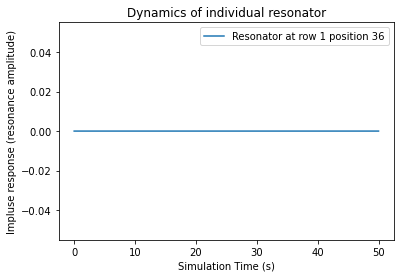

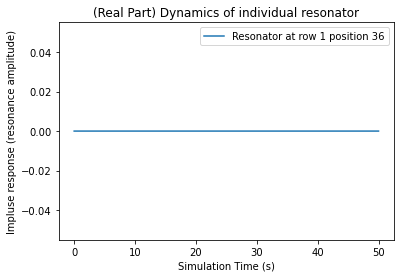

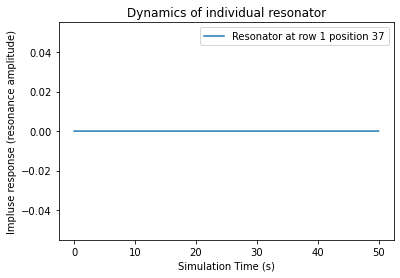

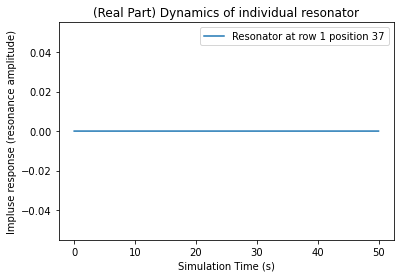

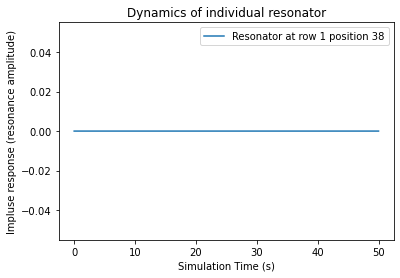

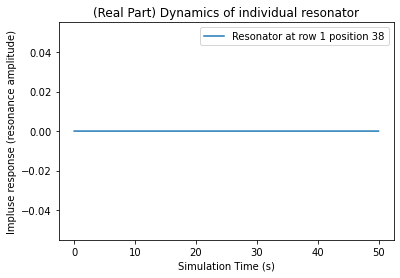

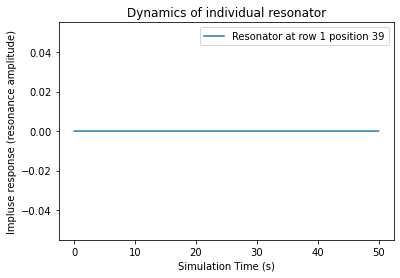

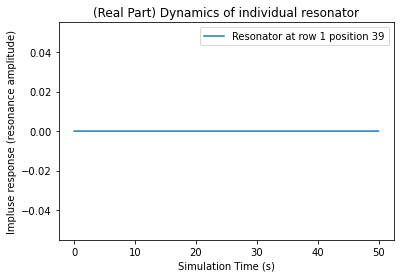

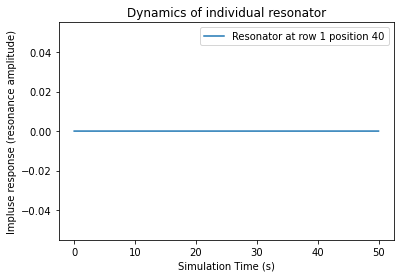

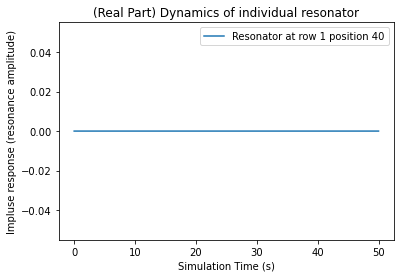

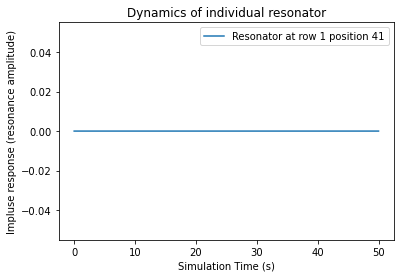

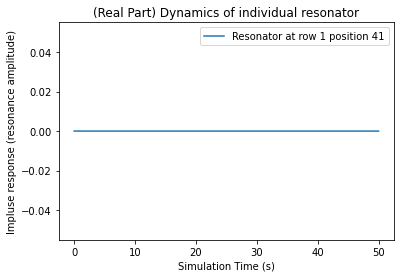

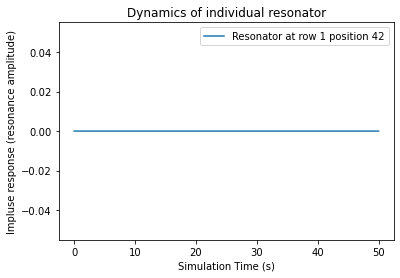

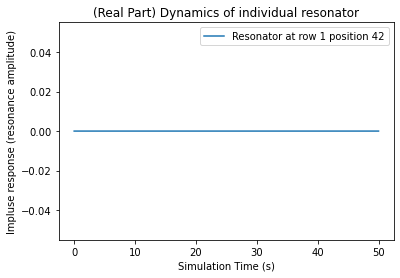

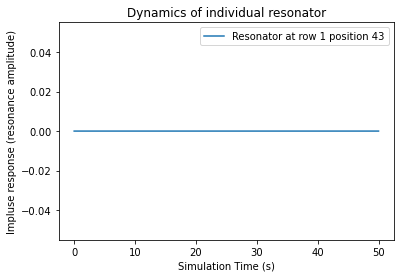

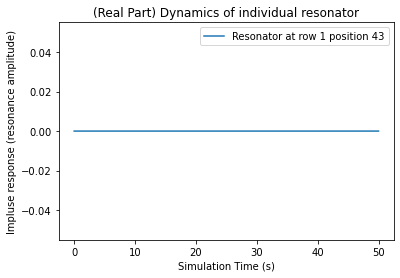

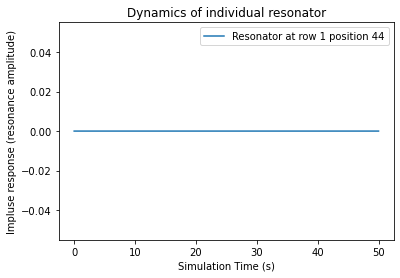

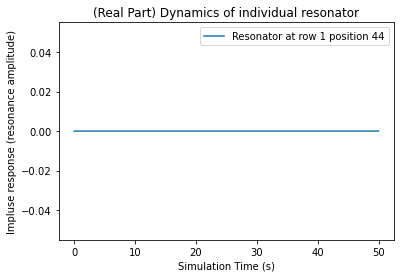

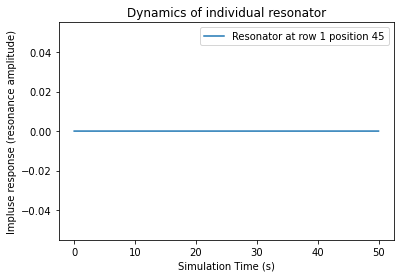

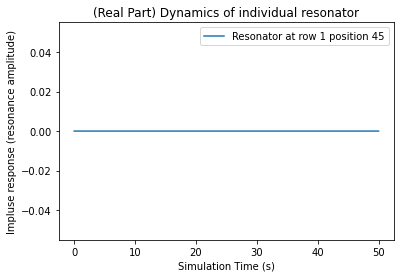

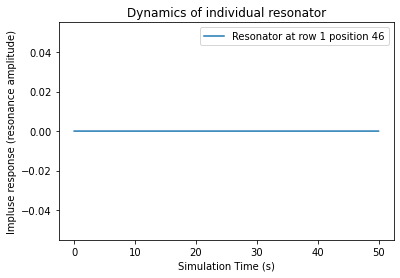

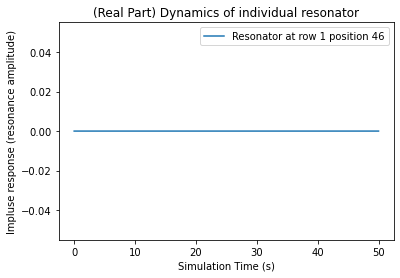

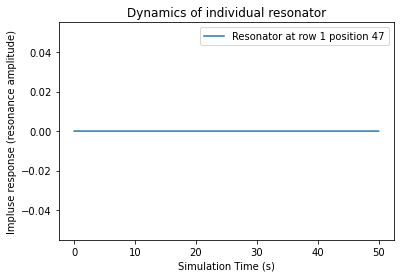

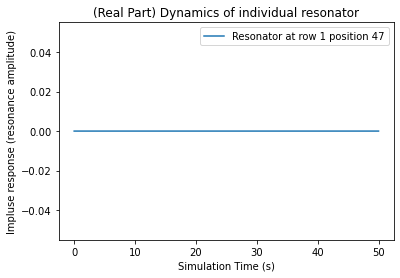

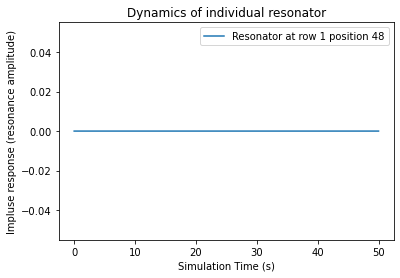

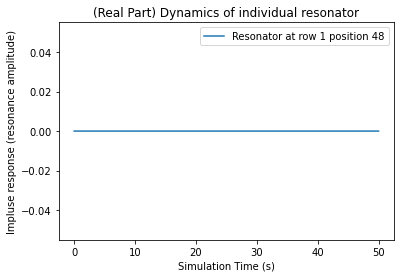

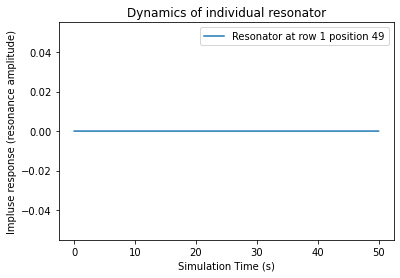

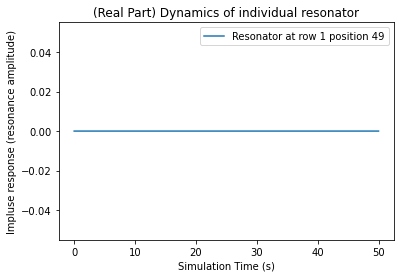

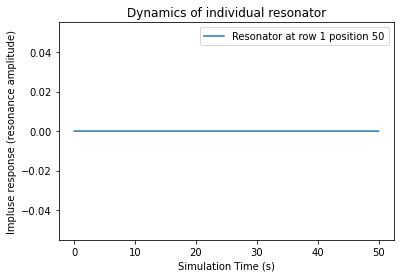

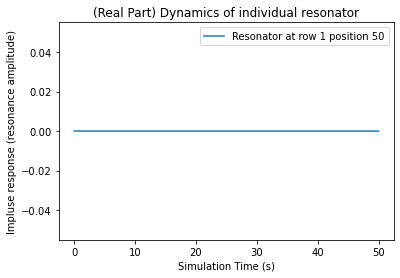

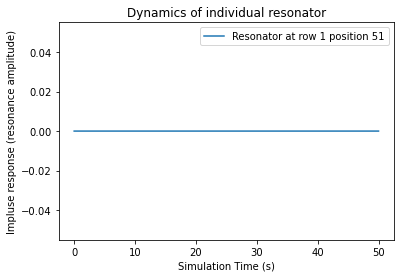

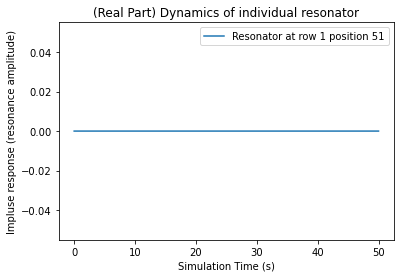

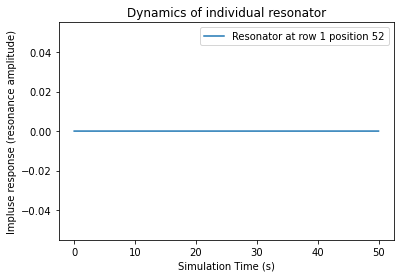

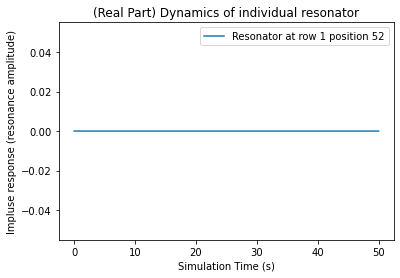

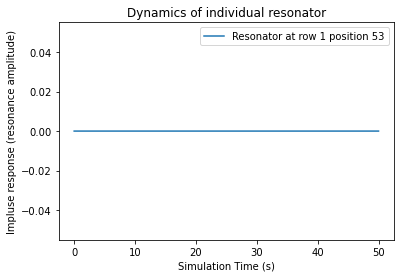

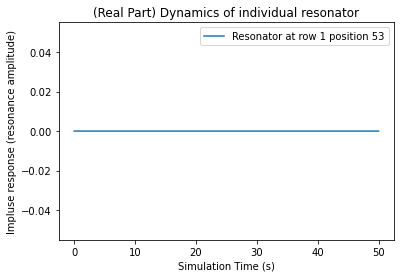

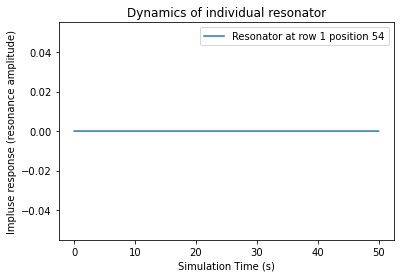

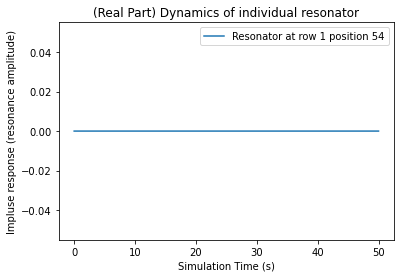

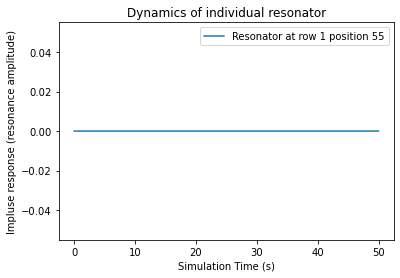

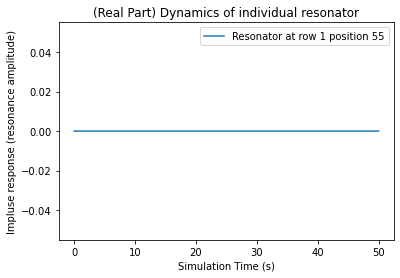

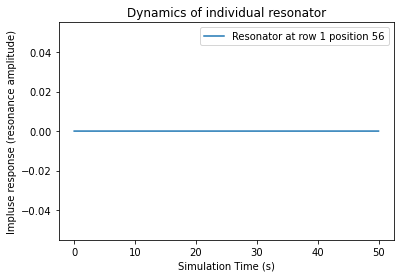

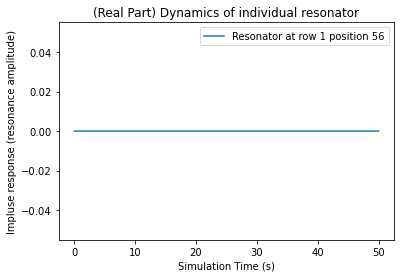

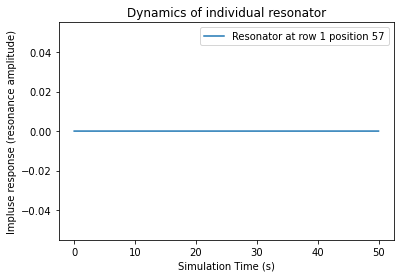

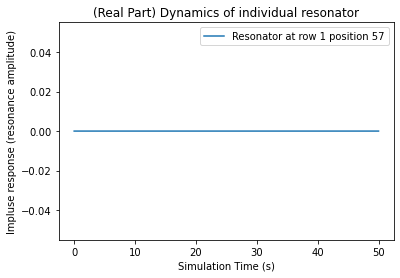

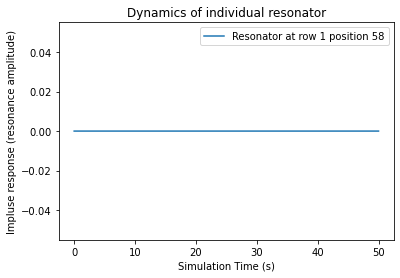

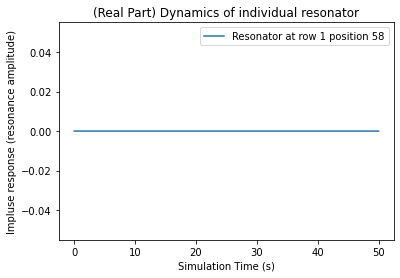

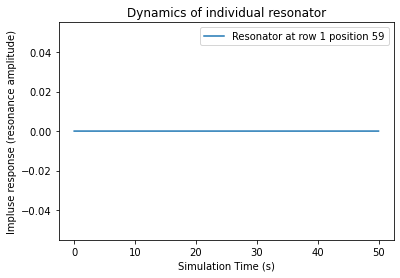

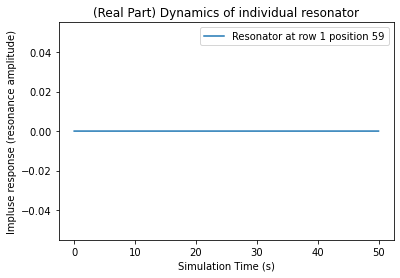

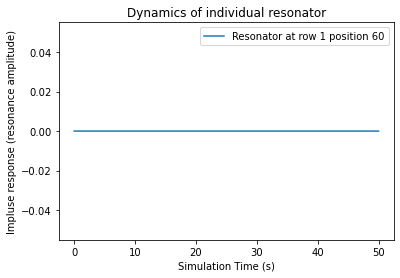

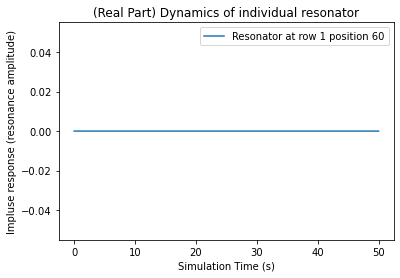

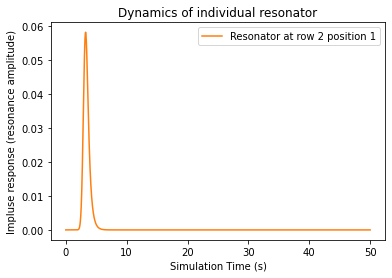

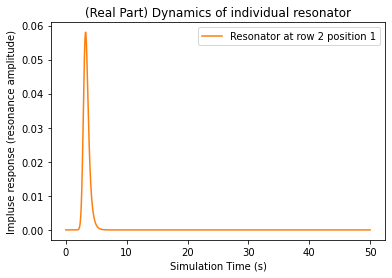

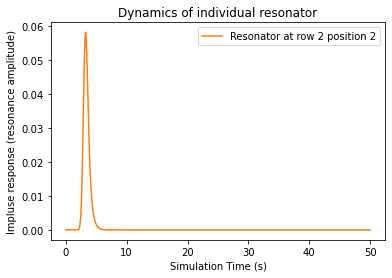

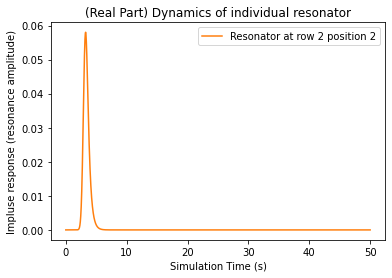

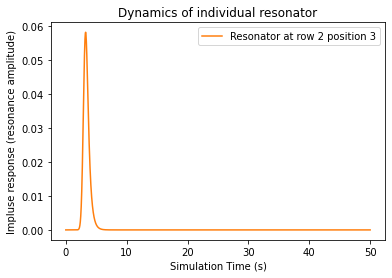

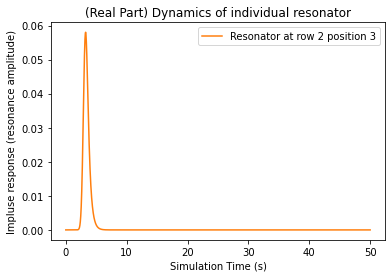

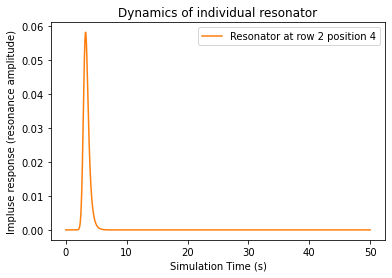

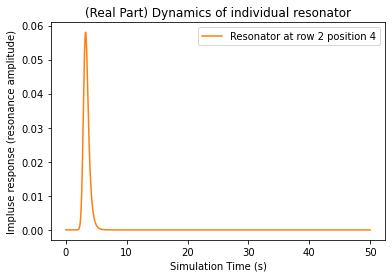

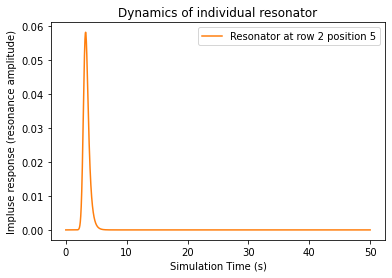

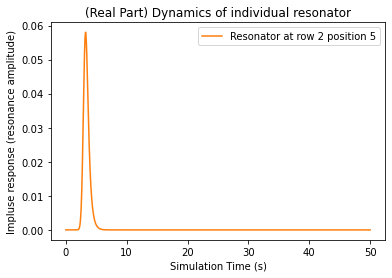

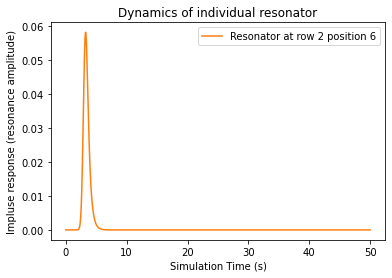

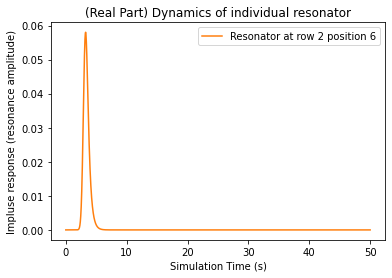

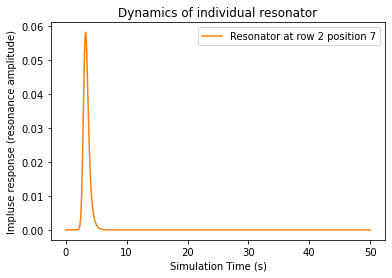

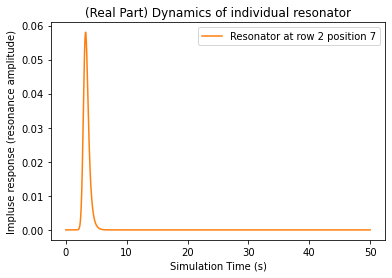

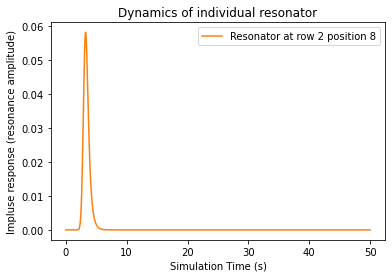

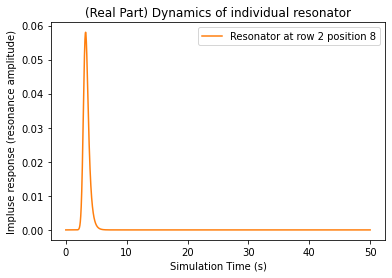

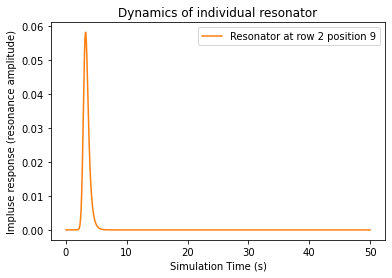

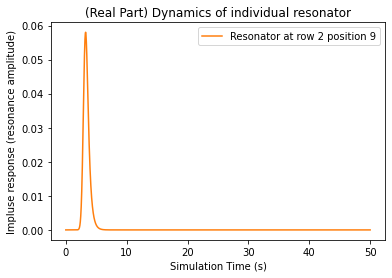

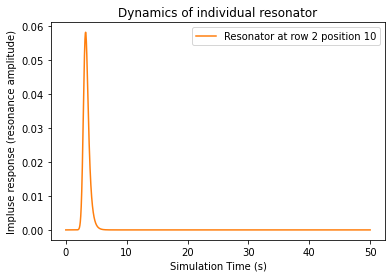

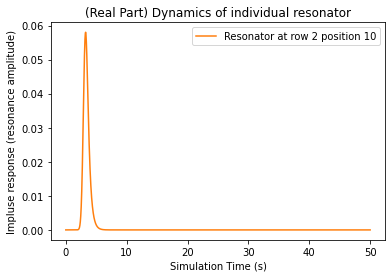

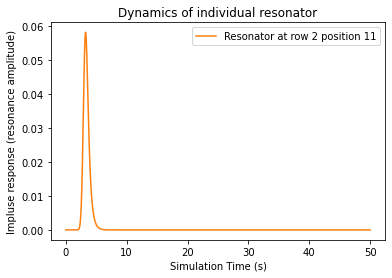

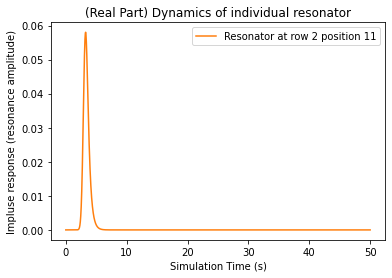

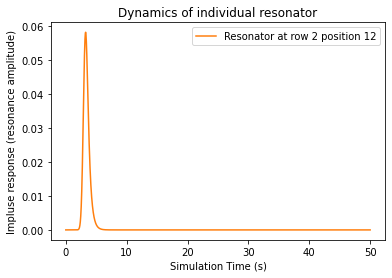

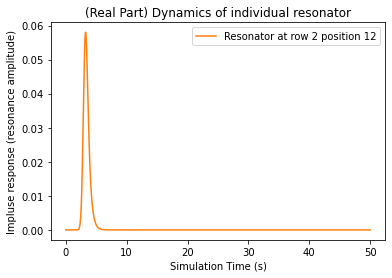

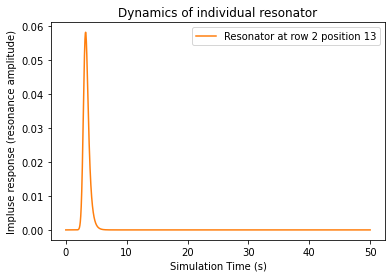

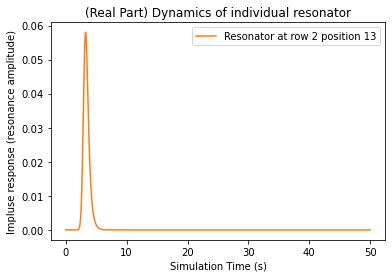

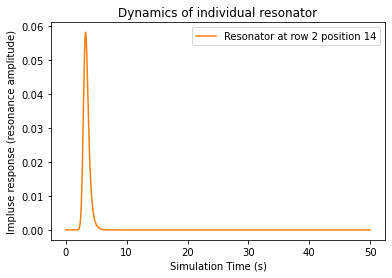

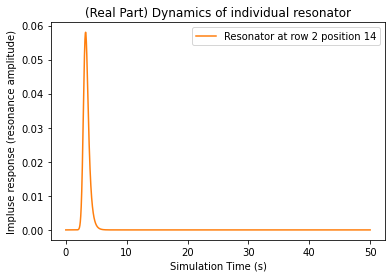

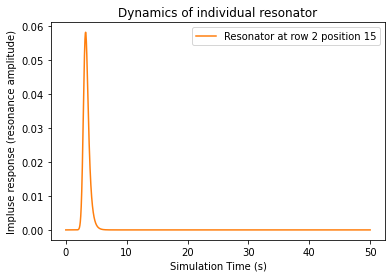

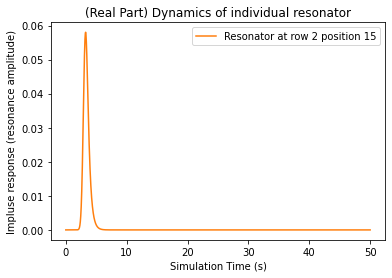

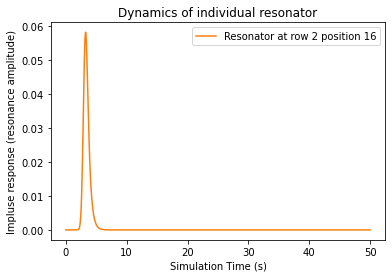

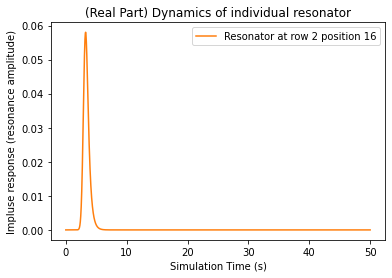

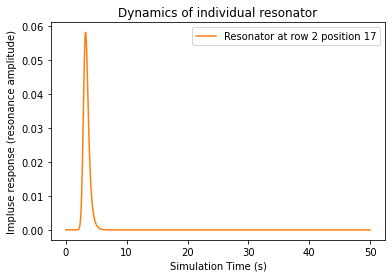

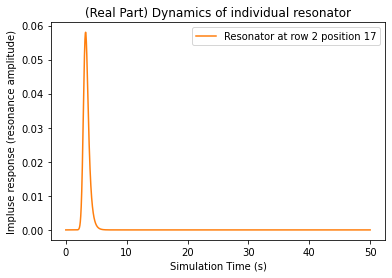

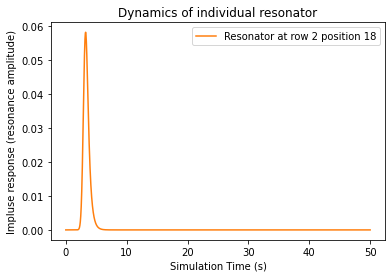

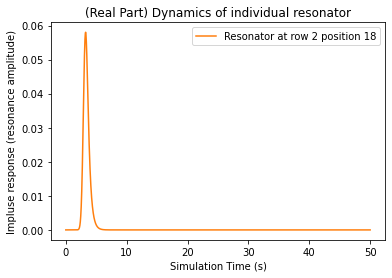

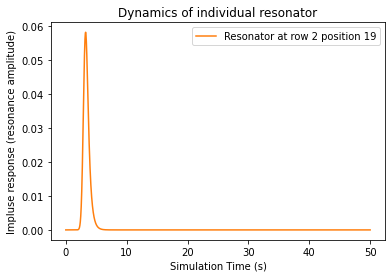

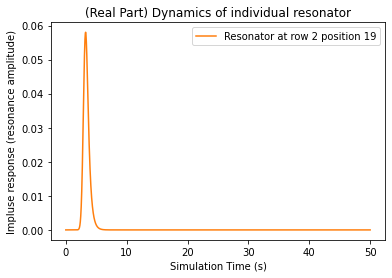

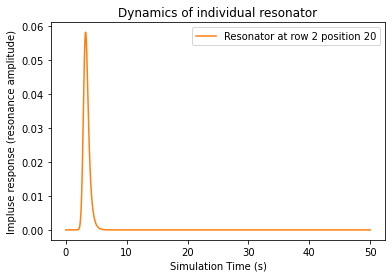

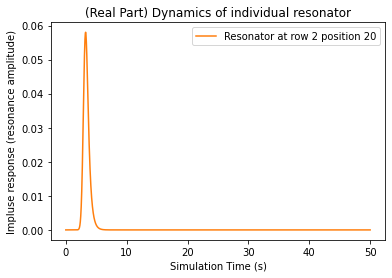

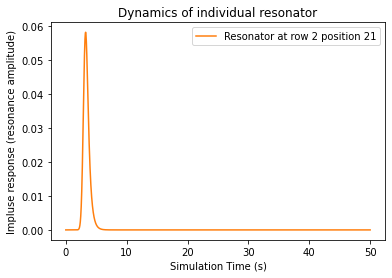

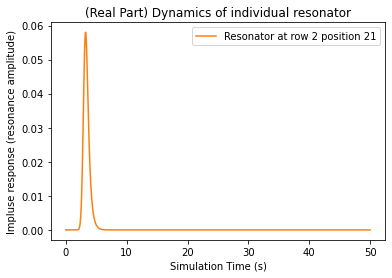

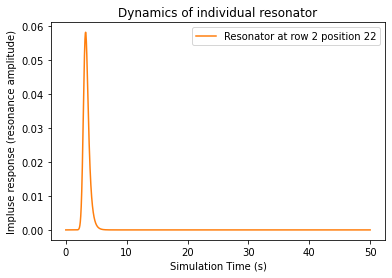

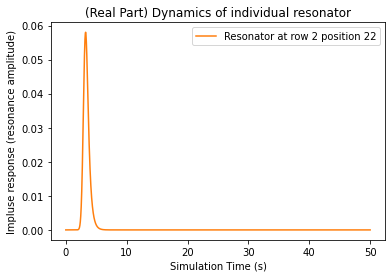

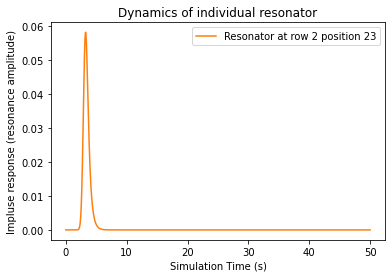

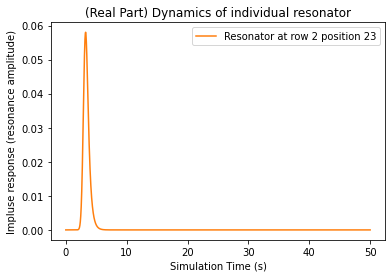

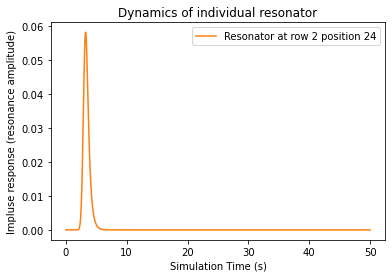

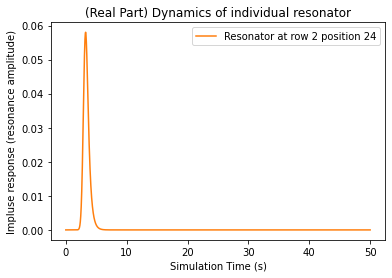

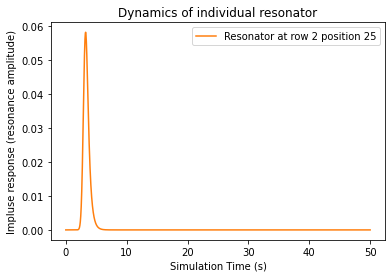

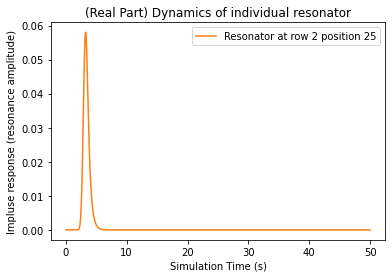

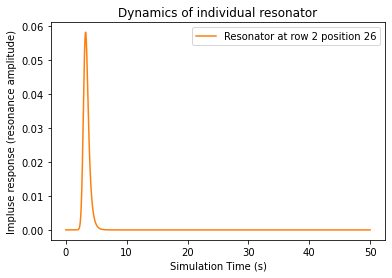

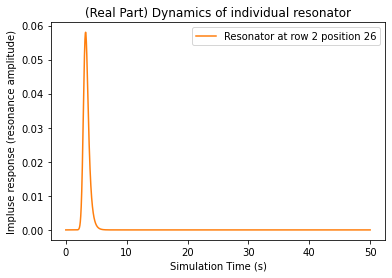

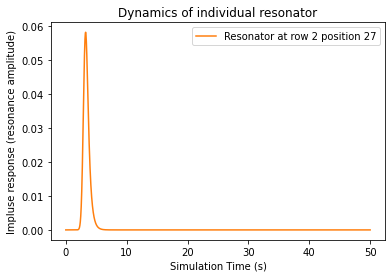

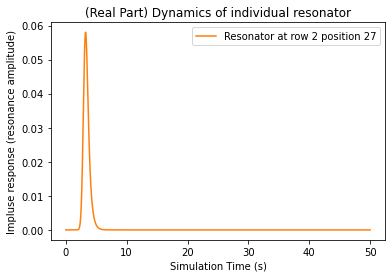

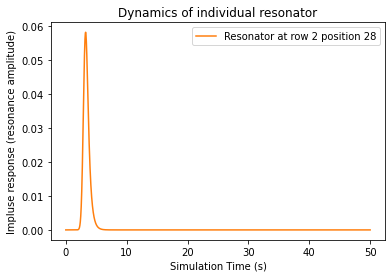

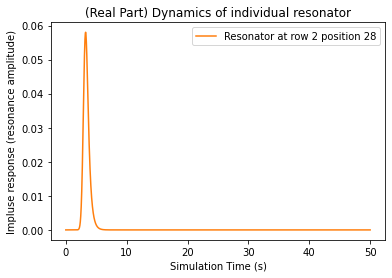

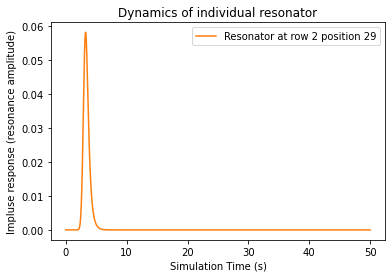

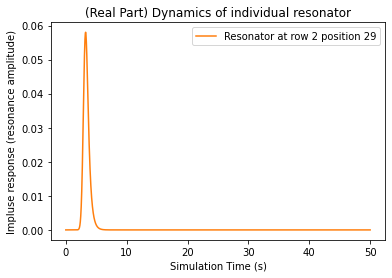

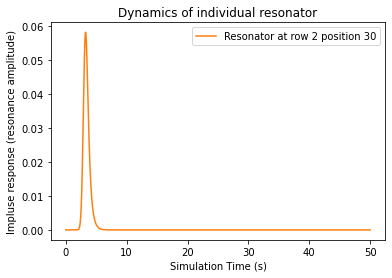

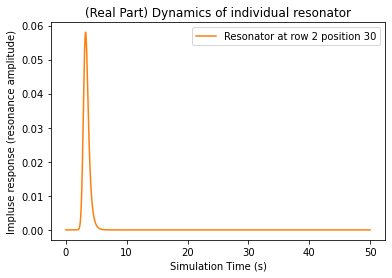

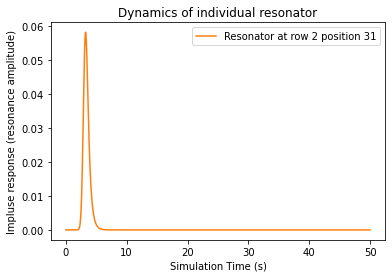

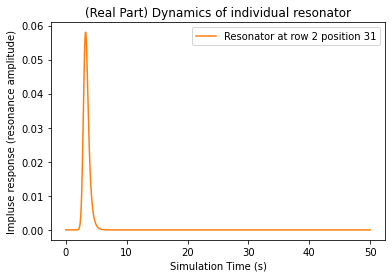

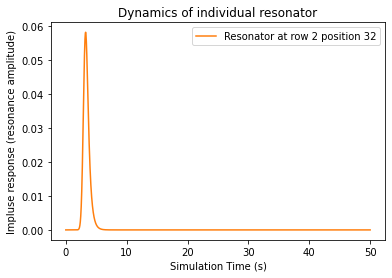

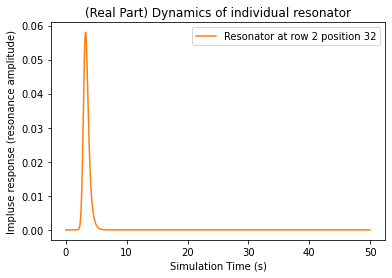

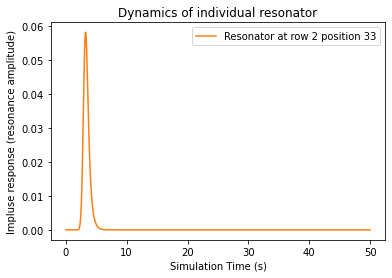

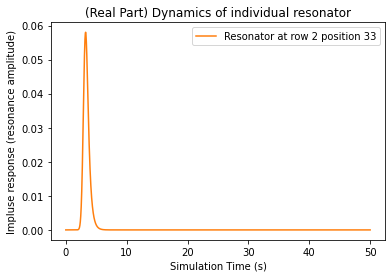

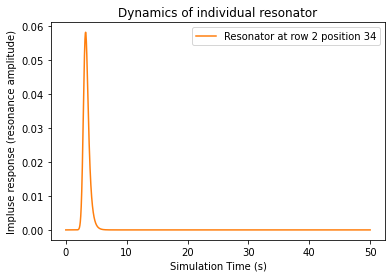

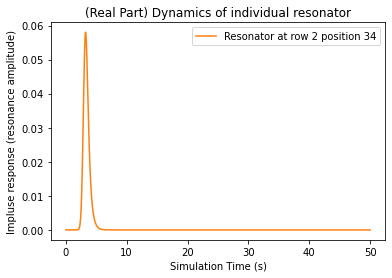

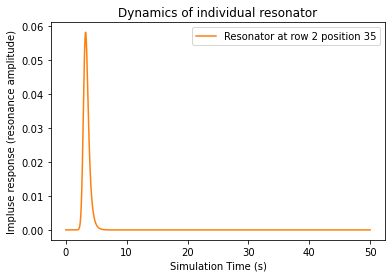

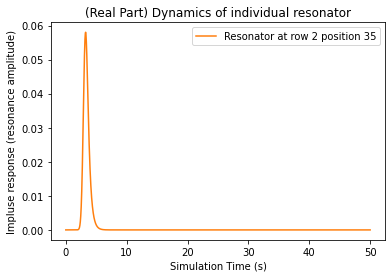

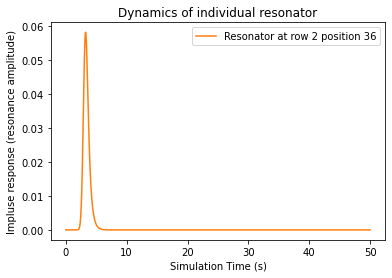

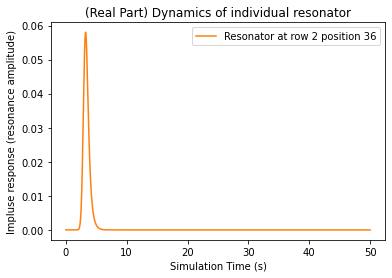

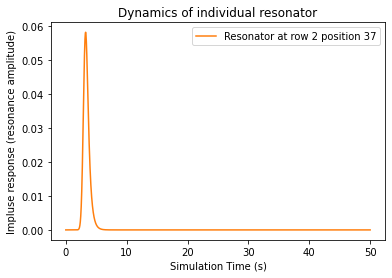

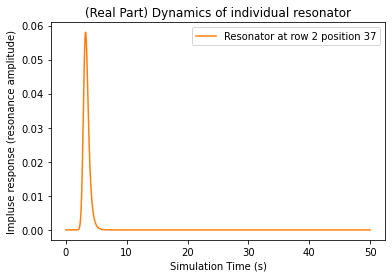

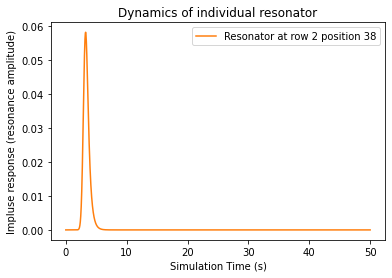

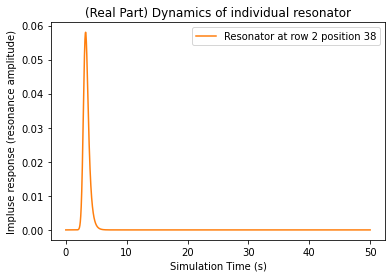

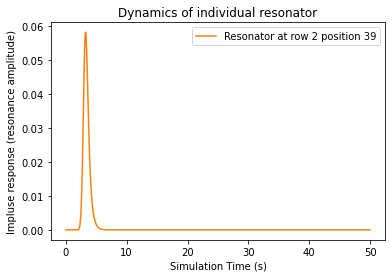

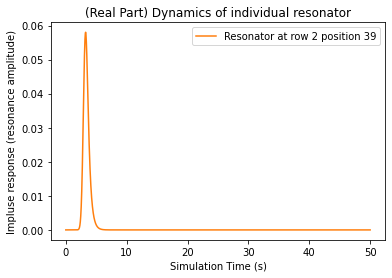

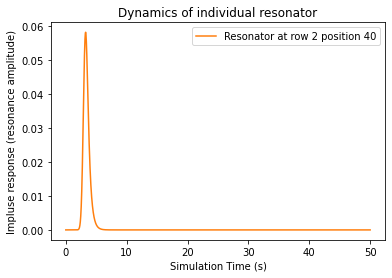

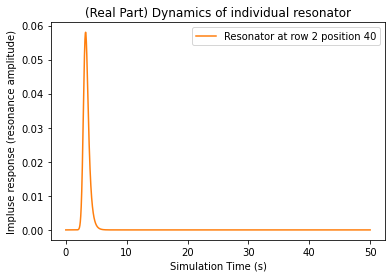

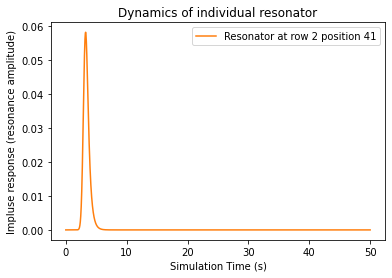

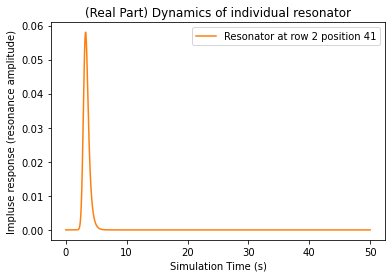

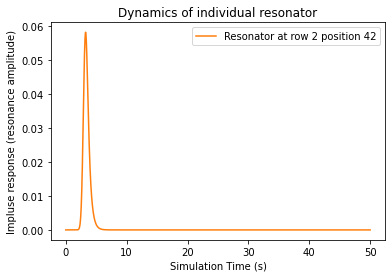

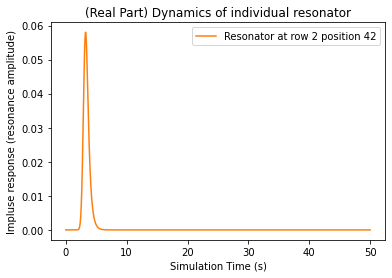

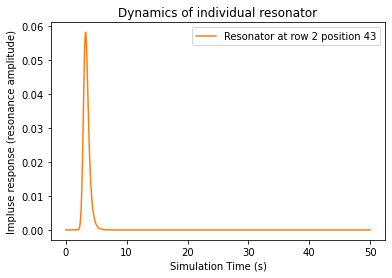

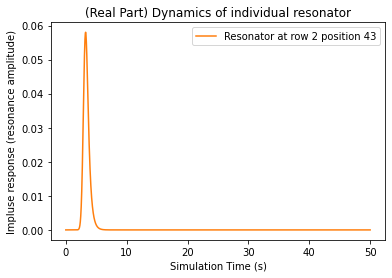

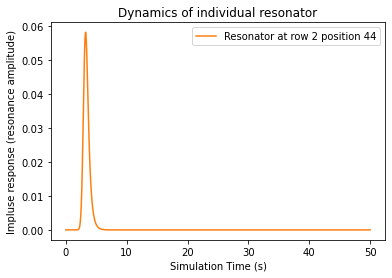

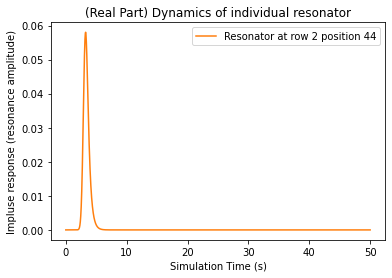

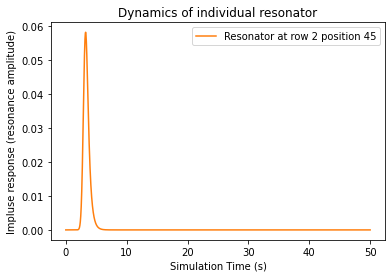

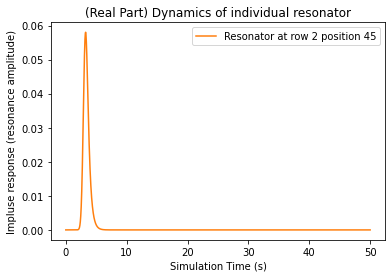

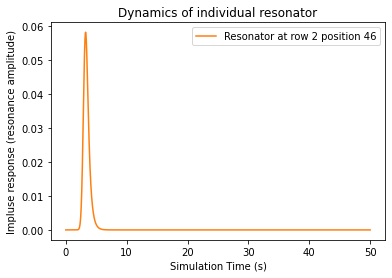

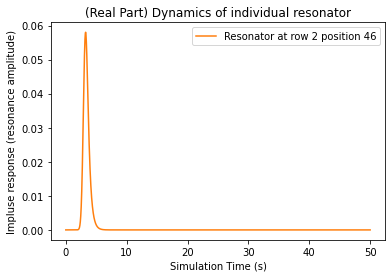

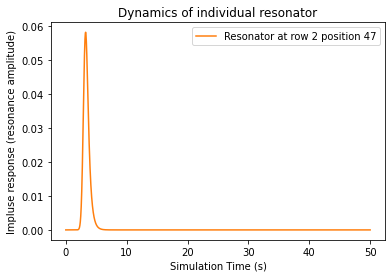

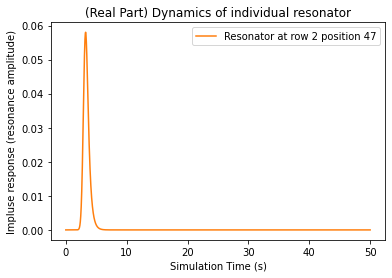

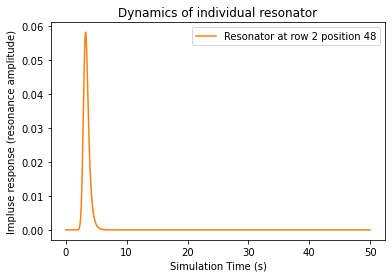

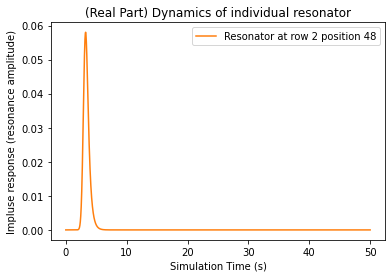

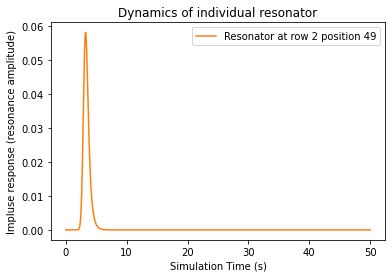

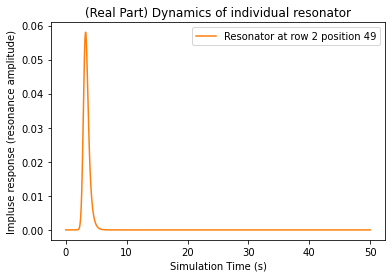

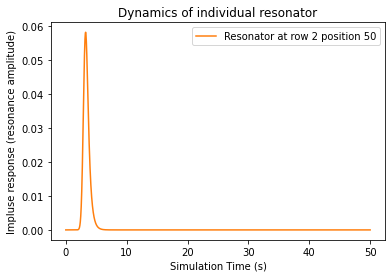

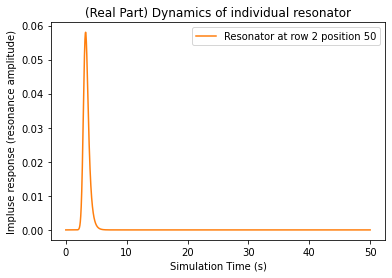

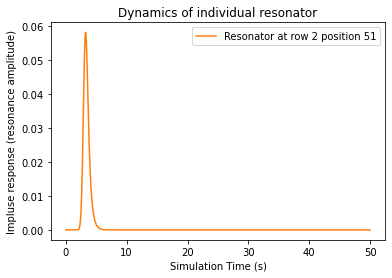

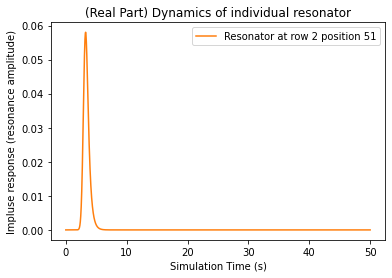

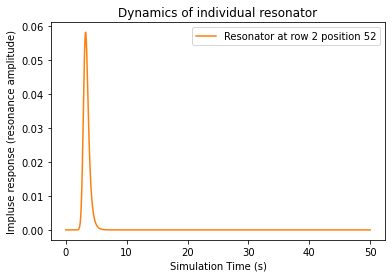

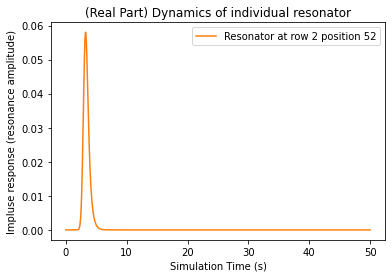

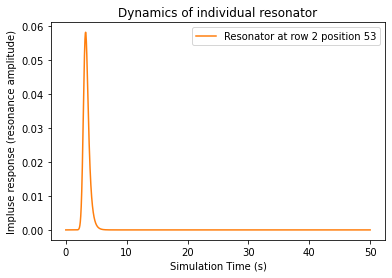

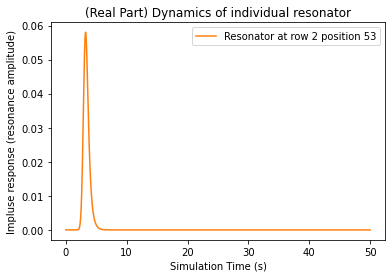

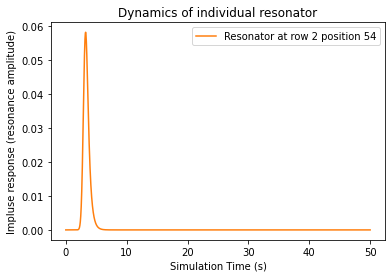

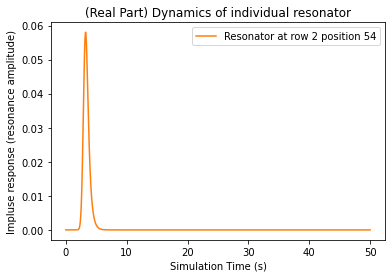

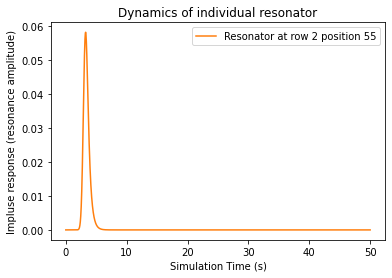

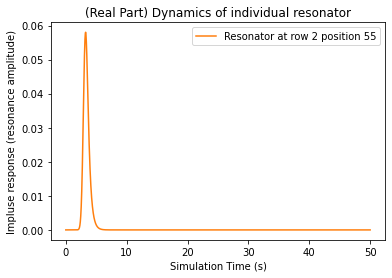

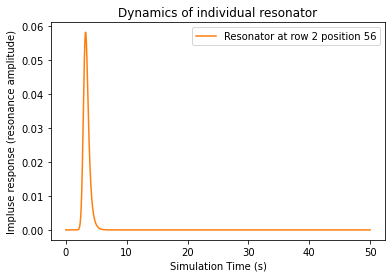

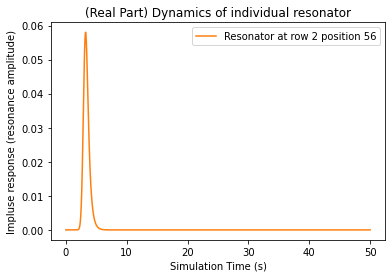

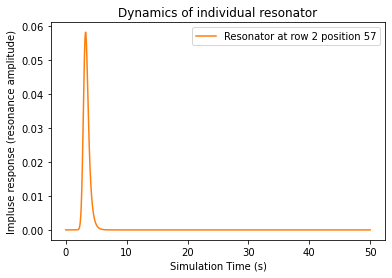

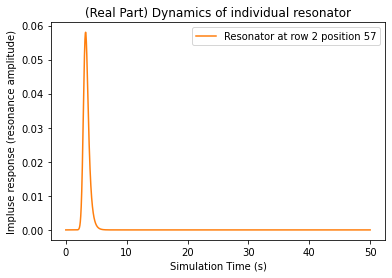

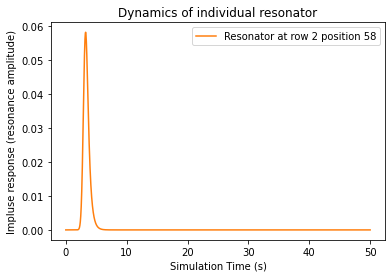

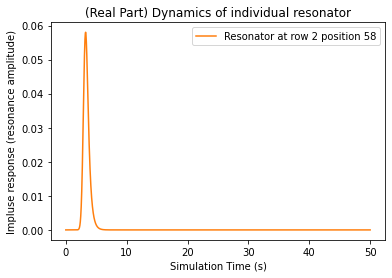

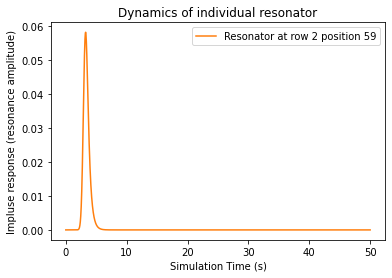

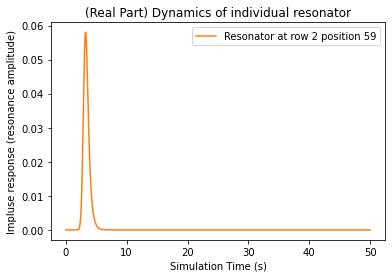

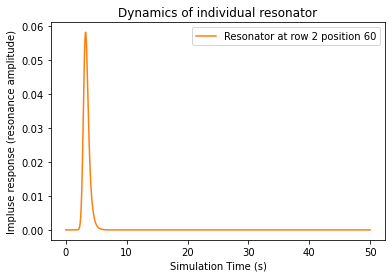

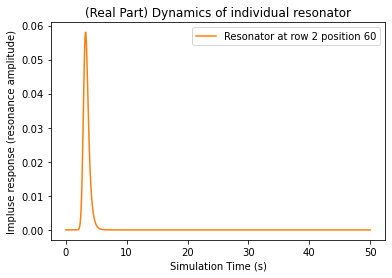

C:\Users\chris\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


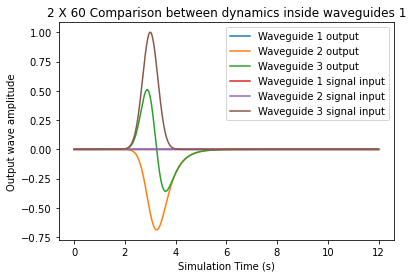

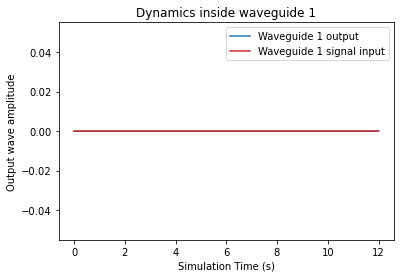

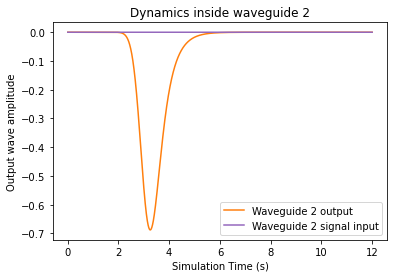

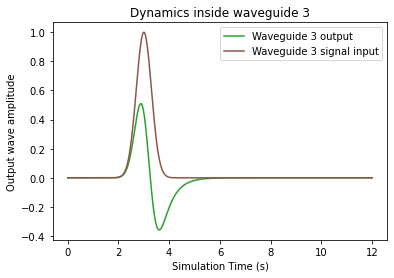

()

In [14]:
n = 60
distribution = 1

temp = np.zeros(2*n)
temp[0] =0.2
Omega = circulant(temp)


temp = np.zeros(2*n)
temp[0] =0.2
Gamma = circulant(temp)

#k = np.array([complex(0.2, 0) for i in range(2*n)])
k = np.array([complex(0, 0) for i in range(2*n)])
for i in range (k.size):
    if i >=n:
        k[i] = complex(0.2,0)
beta = np.array([complex(0.2, 0) for i in range(2*n)])
l = np.array([complex(0.2, 0) for i in range(2*n)])
impulse_response (n, Omega, Gamma, k, beta, l, distribution)


# 3. Forward_pass

In [15]:
vowel_input = []
for i in range (46):
    if i != 0:
        a = read('vowels/m'+str(i)+'ae.wav')
        b = np.array(a[1],dtype=float)
        vowel_input.append(b)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-48. -32. -16. ... -48. -48.   0.]


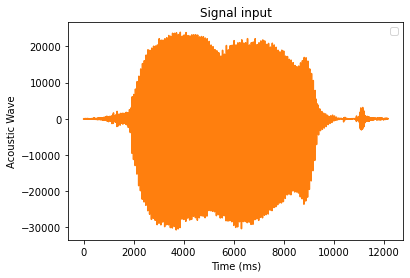

12159


In [16]:
temp = 'vowels/w2ae.wav'
a = read(temp)
b = np.array(a[1],dtype=float)
print (b)
signal_ae = b


plt.plot (signal_ae, label = '', color = 'tab:orange')
plt.title('Signal input')
plt.xlabel('Time (ms)')
plt.ylabel('Acoustic Wave')
plt.legend ()
plt.show()

print (len(signal_ae))

In [17]:
# It is the general function that plot out the impluse response (amplitude of a) of each resonator,
#and the output power inside these three waveguides. 

# n is the number of resonators (= 2*n)
# Omega is the diagonal matrix of resonance frequency
# Gamma is the diagonal matrix of decay rate
# k is the diagonal matrix of coupling coefficient
# beta is the diagonal matrix of wavevector
# l is the diagonal matrix of resonator's position
# Importantly, input_type is the input distribution for three waveguides
def impulse_response (n, Omega, Gamma, k, beta, l, distribution, signal_ae):
    #Firstly, we need to find out the matrix for K (coupling coefficient).
    temp1 = np.array([complex(0, 0) for i in range(6*n)])
    for i in range(6*n):
        if (i< n):
            temp1[i] = k[i] * np.exp(complex(0, 1) *beta[i]*l[i])
        if (2*n<=i< 3*n):
            temp1[i] = k[i-2*n] * np.exp(complex(0, 1)*beta[i-2*n]*l[i-2*n])
        if (3*n<=i< 4*n):
            temp1[i] = k[i-2*n] * np.exp(-complex(0, 1)*beta[i-2*n]*l[i-2*n])
        if (5*n<=i <6*n):
            temp1[i] = k[i-4*n] * np.exp(complex(0, 1)*beta[i-4*n]*l[i-4*n])
    K = temp1.reshape(3,2*n)

    #From K, we can have the matrix H_int
    H_int = 0.5* K.conj().T @ K - Gamma

    #The seires of differential equations that indicates impluse response inside each resonator
    
    #Firstly, let's plug in the i. As is known, there are three waveguides with three 
    #seperate input signals.
    def coupled_res (t,a):
        temp = signal_ae[int(t)]
        S_in = temp * signal_input_distribution(distribution)
        da = (1j * Omega - Gamma - H_int ) @ a + K.transpose() @ S_in
        return da

    
    #set initial inpulse response to be 0!!!! important.
    a_initial = np.array([complex(0, 0) for i in range(2*n)])
    a_initial[0] = 0

    r = complex_ode(coupled_res)
    r.set_initial_value(a_initial, 0)

    #Simulation time is 50s, which is enough for the simple simulation now. 
    max_time = len(signal_ae)-1
    depth = 1

    time_interval = []
    a_complex = []
    
    while r.successful() and r.t < max_time:
        x = r.t+ depth
        y = r.integrate(x)
        a_complex.append (y)
        time_interval.append (x)
        
    #saves the value of a and value of |a|. 
    a_complex = np.array (a_complex)
    a_amp = np.zeros((len(a_complex),len(a_complex[0])))
    a_real = np.zeros((len(a_complex),len(a_complex[0])))
    for i in range (len(a_complex)):
        for j in range (len(a_complex[0])):
            a_amp[i][j] = abs(a_complex[i][j])
            a_real[i][j] = a_complex[i][j].real

    
    #plots of each |a|
    
    
    for i in range (2*n):
        if (1+i//n == 1):
            name = 'tab:blue'
        if (1+i//n == 2):
            name ='tab:orange'
        
        #plt.plot (time_interval, a_real[:,i], label = 'Resonator at row '+str(1+i//n) +' position '+ str(1+i - n* (i//n)), color =name )
        #plt.title('(Real Part) Dynamics of individual resonator')
        #plt.xlabel('Simulation Time (s)')
        #plt.ylabel('Impluse response (resonance amplitude)')
        #plt.legend ()
        #plt.show()
    
    def S_in (t):
        y = signal_ae[int(t)] * signal_input_distribution(distribution)
        return y
    
    max_time = len(signal_ae)-1
    depth = 1
    
    time_interval = []
    
    i=0
    while i < max_time:
        i+=depth
        time_interval.append(i)
    
    S_out = []
    S_in_plot = []
    for i in range(len(time_interval)):
        aa = K.conj() @ a_complex[i]
        temp =  np.exp(-0.2*0.2*0.2)* (S_in(time_interval[i]) - aa)
        S_out.append(temp)
        S_in_plot.append(S_in(time_interval[i]))
    
    S1 =[]
    S2= []
    S3= []
    S_in_plot1 =[]
    S_in_plot2=[]
    S_in_plot3=[]
    for i in range (len(S_out)):
        S1.append(S_out[i][0])
        S2.append(S_out[i][1])
        S3.append(S_out[i][2])
        S_in_plot1.append(S_in_plot[i][0].real)
        S_in_plot2.append(S_in_plot[i][1].real)
        S_in_plot3.append(S_in_plot[i][2].real)
        
        
    
    #plt.plot (time_interval, S1, label = 'Waveguide 1 output', color = 'tab:blue')
    #plt.plot (time_interval, S2, label = 'Waveguide 2 output', color = 'tab:orange')
    #plt.plot (time_interval, S3, label = 'Waveguide 3 output', color = 'tab:green')
    #plt.plot (time_interval, S_in_plot1, label = 'Waveguide 1 signal input' , color = 'tab:red')
    #plt.plot (time_interval, S_in_plot2, label = 'Waveguide 2 signal input', color = 'tab:purple')
    #plt.plot (time_interval, S_in_plot3, label = 'Waveguide 3 signal input', color = 'tab:brown')
    #plt.title('2 X %.0f Comparison between dynamics inside waveguides %.0f' %(n ,distribution))
    #plt.xlabel('Simulation Time (s)')
    #plt.ylabel('Output wave amplitude')
    #plt.legend ()
    #plt.show()  


    '''
    plt.plot (time_interval, S1, label = 'Waveguide 1 output', color = 'tab:blue')
    plt.title('Dynamics inside waveguide 1')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()
    
    plt.plot (time_interval, S_in_plot1, label = 'Waveguide 1 signal input', color = 'tab:red')
    plt.title('Dynamics inside waveguide 1')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()
    

    plt.plot (time_interval, S2, label = 'Waveguide 2 output', color = 'tab:orange')
    plt.title('Dynamics inside waveguide 2')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()
    
    plt.plot (time_interval, S_in_plot2, label = 'Waveguide 2 signal input', color = 'tab:purple')
    plt.title('Dynamics inside waveguide 2')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()
    
    plt.plot (time_interval, S3, label = 'Waveguide 3 output', color = 'tab:green')
    plt.title('Dynamics inside waveguide 3')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()

    plt.plot (time_interval, S_in_plot3, label = 'Waveguide 3 signal input', color = 'tab:brown')
    plt.title('Dynamics inside waveguide 3')
    plt.xlabel('Simulation Time (s)')
    plt.ylabel('Output wave amplitude')
    plt.legend ()
    plt.show()
    '''
    
    list_return =[]
    list_return.append (S_in_plot1)
    list_return.append (S1)
    list_return.append (S_in_plot2)
    list_return.append (S2)
    list_return.append (S_in_plot3)
    list_return.append (S3)
    
    return (list_return)

In [18]:
n = 2
distribution = 1

temp = np.zeros(2*n)
temp[0] =0.2
Omega = circulant(temp)

temp = np.zeros(2*n)
temp[0] =0.2
Gamma = circulant(temp)

k = np.array([complex(0.2, 0) for i in range(2*n)])
#k = np.array([complex(0, 0) for i in range(2*n)])
for i in range (k.size):
    if i >=n:
        k[i] = complex(0.2,0)
beta = np.array([complex(0.2, 0) for i in range(2*n)])
l = np.array([complex(0.2, 0) for i in range(2*n)])

waveguide_1_input = []
waveguide_1_output = []
waveguide_2_input = []
waveguide_2_output = []
waveguide_3_input = []
waveguide_3_output = []
for i in range (len(vowel_input)):
    signal_ae = vowel_input[i]
    temp = impulse_response (n, Omega, Gamma, k, beta, l, distribution, signal_ae)
    waveguide_1_input.append(temp[0])
    waveguide_1_output.append(temp[1])
    waveguide_2_input.append(temp[2])
    waveguide_2_output.append(temp[3])
    waveguide_3_input.append(temp[4])
    waveguide_3_output.append(temp[5])

In [19]:
waveguide_1_input = np.array(waveguide_1_input)
waveguide_1_output = np.array(waveguide_1_output)


waveguide_2_input = np.array(waveguide_2_input)
waveguide_2_output = np.array(waveguide_2_output)

waveguide_3_input = np.array(waveguide_3_input)
waveguide_3_output = np.array(waveguide_3_output)


C:\Users\chris\AppData\Local\Temp/ipykernel_15936/3503600476.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  waveguide_1_input = np.array(waveguide_1_input)
C:\Users\chris\AppData\Local\Temp/ipykernel_15936/3503600476.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  waveguide_1_output = np.array(waveguide_1_output)
C:\Users\chris\AppData\Local\Temp/ipykernel_15936/3503600476.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes

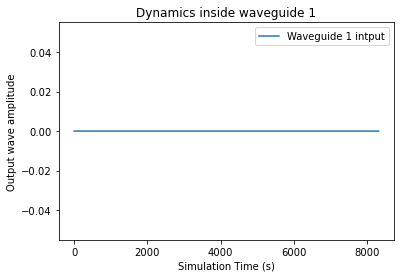

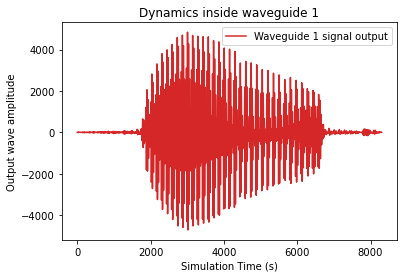

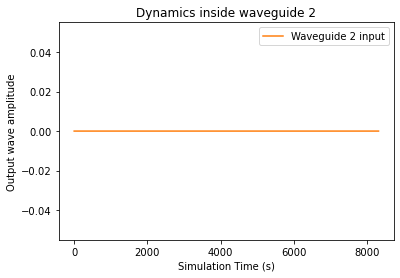

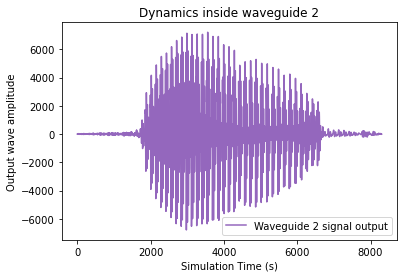

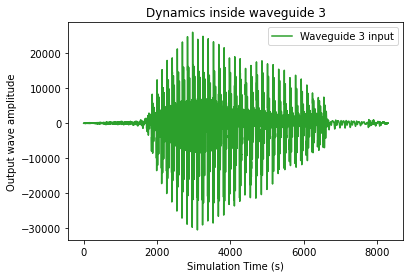

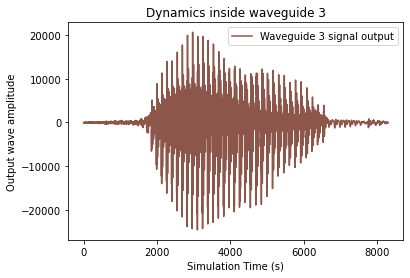

In [20]:
xx=4

plt.plot (waveguide_1_input[xx], label = 'Waveguide 1 intput', color = 'tab:blue')
plt.title('Dynamics inside waveguide 1')
plt.xlabel('Simulation Time (s)')
plt.ylabel('Output wave amplitude')
plt.legend ()
plt.show()

plt.plot (waveguide_1_output[xx], label = 'Waveguide 1 signal output', color = 'tab:red')
plt.title('Dynamics inside waveguide 1')
plt.xlabel('Simulation Time (s)')
plt.ylabel('Output wave amplitude')
plt.legend ()
plt.show()


plt.plot (waveguide_2_input[xx], label = 'Waveguide 2 input', color = 'tab:orange')
plt.title('Dynamics inside waveguide 2')
plt.xlabel('Simulation Time (s)')
plt.ylabel('Output wave amplitude')
plt.legend ()
plt.show()

plt.plot (waveguide_2_output[xx], label = 'Waveguide 2 signal output', color = 'tab:purple')
plt.title('Dynamics inside waveguide 2')
plt.xlabel('Simulation Time (s)')
plt.ylabel('Output wave amplitude')
plt.legend ()
plt.show()


plt.plot (waveguide_3_input[xx], label = 'Waveguide 3 input', color = 'tab:green')
plt.title('Dynamics inside waveguide 3')
plt.xlabel('Simulation Time (s)')
plt.ylabel('Output wave amplitude')
plt.legend ()
plt.show()

plt.plot (waveguide_3_output[xx], label = 'Waveguide 3 signal output', color = 'tab:brown')
plt.title('Dynamics inside waveguide 3')
plt.xlabel('Simulation Time (s)')
plt.ylabel('Output wave amplitude')
plt.legend ()
plt.show()
